# **Data Driven Engineering 1 - Final Project**

Lecture: Data Driven Engineering 1 at ITS, KIT


Author: Tobias Höfchen


# Problem Definition: Probe into the Data

## Describing the data
This dataset describes the relationship between eyestate (open/close) and nerve activity. The data has been collected during a 117 second long EEG [[1]].

The dataset contains 14 different electrode measurements (electrodes that are placed on the patients head) and 1 output, which has been added manually after the measurement has been taken [[1]].
The different columnnames are:
- AF3
- F7
- F3
- FC5
- T7
- P7
- O1
- O2
- P8
- T8
- FC6
- F4
- F8
- AF4
- eyeDetection: 0-open state / 1-closed state

The columnnames represent different locations on the head. They can be looked up __[here](https://www.easycap.de/wp-content/uploads/2018/02/Easycap-10-based-electrode-layouts.pdf)__. Each column contains the numerical electrode output in a hierarchical order.

*** 
## Describing the problem
I think this dataset is useful to explore in order to detect ocular deseases or nerve deseases in general. It could be useful in automated driving to check wether the driver becomes tired and hence should take a rest. Besides that, ocular deseases that cause a different blinking behaviour may be detected. E.g. it could help diagnosing __[blepharospasm](https://www.cordingleyneurology.com/blepharospasm.html)__.

*In order to reach the claimed goals you have to create a model that detects the eyestate based on the EEG data and a model that classifies wether a persons eye is open or closed.*

Due to the fact, that i only have data of one EEG, **my goal is to create a classifier that determines the eye state based on the electrode measurements.** For the second model more EEG data is required in order to train the classification model. 

[1]: https://archive.ics.uci.edu/ml/datasets/EEG+Eye+State#

# Preparing the environment

In [ ]:
# Silence deprecated warning
import warnings
warnings.filterwarnings("ignore", category=FutureWarning) 

In [ ]:
#Importing necessary libraries
import time
import pandas as pd
import numpy as np
import urllib.request
from io import StringIO 
from scipy.io.arff import loadarff
import matplotlib.pyplot as plt
import math
import seaborn as sns
import plotly.graph_objects as go

In [ ]:
# Data preparation
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import log_loss, make_scorer
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix, ConfusionMatrixDisplay
import plotly.express as px

In [ ]:
# ML Algorithms to be used in Testing Phase I
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import lightgbm as LGBMClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA

# ML Algorithms to be used in Testing Phase II
import tensorflow as tf
from tensorflow import keras
from keras import optimizers, models, layers, regularizers


In [ ]:
#mounting google drive to colab
from google.colab import drive
drive.mount('/content/gdrive')

#if errors occur look https://stackoverflow.com/questions/69819761/i-cant-mount-my-another-drive-in-google-colab.

Mounted at /content/gdrive


# Data preprocessing

## Loading the data


In [ ]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00264/EEG%20Eye%20State.arff'
resp = urllib.request.urlopen(url)
data = pd.DataFrame(loadarff(StringIO(resp.read().decode('utf-8')))[0])
data.head()

,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4,eyeDetection
0,4329.23,4009.23,4289.23,4148.21,4350.26,4586.15,4096.92,4641.03,4222.05,4238.46,4211.28,4280.51,4635.90,4393.85,b'0'
1,4324.62,4004.62,4293.85,4148.72,4342.05,4586.67,4097.44,4638.97,4210.77,4226.67,4207.69,4279.49,4632.82,4384.10,b'0'
2,4327.69,4006.67,4295.38,4156.41,4336.92,4583.59,4096.92,4630.26,4207.69,4222.05,4206.67,4282.05,4628.72,4389.23,b'0'
3,4328.72,4011.79,4296.41,4155.90,4343.59,4582.56,4097.44,4630.77,4217.44,4235.38,4210.77,4287.69,4632.31,4396.41,b'0'
4,4326.15,4011.79,4292.31,4151.28,4347.69,4586.67,4095.90,4627.69,4210.77,4244.10,4212.82,4288.21,4632.82,4398.46,b'0'


Rename eyeDetection with eyeState.

In [ ]:
data = data.rename(columns={"eyeDetection" : "eyeState"})

## Data Exploration

We will look into the gathered data to gather a better understanding of the numerical properties of our data. We will check for example for missing values, and what kind of features we have etc.

In [ ]:
data.describe()

,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4
count,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000
mean,4321.917777,4009.767694,4264.022433,4164.946326,4341.741075,4644.022379,4110.400160,4616.056904,4218.826610,4231.316200,4202.456900,4279.232774,4615.205336,4416.435832
std,2492.072174,45.941672,44.428052,5216.404632,34.738821,2924.789537,4600.926543,29.292603,2136.408523,38.050903,37.785981,41.544312,1208.369958,5891.285043
min,1030.770000,2830.770000,1040.000000,2453.330000,2089.740000,2768.210000,2086.150000,4567.180000,1357.950000,1816.410000,3273.330000,2257.950000,86.666700,1366.150000
25%,4280.510000,3990.770000,4250.260000,4108.210000,4331.790000,4611.790000,4057.950000,4604.620000,4190.770000,4220.510000,4190.260000,4267.690000,4590.770000,4342.050000
50%,4294.360000,4005.640000,4262.560000,4120.510000,4338.970000,4617.950000,4070.260000,4613.330000,4199.490000,4229.230000,4200.510000,4276.920000,4603.080000,4354.870000
75%,4311.790000,4023.080000,4270.770000,4132.310000,4347.180000,4626.670000,4083.590000,4624.100000,4209.230000,4239.490000,4211.280000,4287.180000,4617.440000,4372.820000
max,309231.000000,7804.620000,6880.510000,642564.000000,6474.360000,362564.000000,567179.000000,7264.100000,265641.000000,6674.360000,6823.080000,7002.560000,152308.000000,715897.000000


Since all columns have the same amount of "count" there's no missing data. In terms of outliers there might be some in "AF3", "FC5", "P7", "O1", "P8", "F8" and "AF4". These values *might* be outliers, but they could also just simply represent one specific eye state if we have an pretty unbalanced dataset (otherwise the max value would be closer to the mean). We will explore that in section Data Visualization.

In [ ]:
data.head()

,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4,eyeState
0,4329.23,4009.23,4289.23,4148.21,4350.26,4586.15,4096.92,4641.03,4222.05,4238.46,4211.28,4280.51,4635.90,4393.85,b'0'
1,4324.62,4004.62,4293.85,4148.72,4342.05,4586.67,4097.44,4638.97,4210.77,4226.67,4207.69,4279.49,4632.82,4384.10,b'0'
2,4327.69,4006.67,4295.38,4156.41,4336.92,4583.59,4096.92,4630.26,4207.69,4222.05,4206.67,4282.05,4628.72,4389.23,b'0'
3,4328.72,4011.79,4296.41,4155.90,4343.59,4582.56,4097.44,4630.77,4217.44,4235.38,4210.77,4287.69,4632.31,4396.41,b'0'
4,4326.15,4011.79,4292.31,4151.28,4347.69,4586.67,4095.90,4627.69,4210.77,4244.10,4212.82,4288.21,4632.82,4398.46,b'0'


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14980 entries, 0 to 14979
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   AF3       14980 non-null  float64
 1   F7        14980 non-null  float64
 2   F3        14980 non-null  float64
 3   FC5       14980 non-null  float64
 4   T7        14980 non-null  float64
 5   P7        14980 non-null  float64
 6   O1        14980 non-null  float64
 7   O2        14980 non-null  float64
 8   P8        14980 non-null  float64
 9   T8        14980 non-null  float64
 10  FC6       14980 non-null  float64
 11  F4        14980 non-null  float64
 12  F8        14980 non-null  float64
 13  AF4       14980 non-null  float64
 14  eyeState  14980 non-null  object 
dtypes: float64(14), object(1)
memory usage: 1.7+ MB


Every column has the same type - float64, which is good because therefore we can use them as they are for numerical calculations. The datatype *object* has to be corrected for further calculations.

### Correction of "object" type

In [ ]:
data.eyeState = [int(str(i, "utf-8")) for i in data.eyeState]
type(data.eyeState.iloc[0])

numpy.int64

In [ ]:
distinctCounter = data.apply(lambda x: len(x.unique()))
print(distinctCounter)

AF3         548
F7          452
F3          345
FC5         312
T7          285
P7          330
O1          290
O2          294
P8          304
T8          346
FC6         419
F4          343
F8          558
AF4         592
eyeState      2
dtype: int64


### Check for duplicate rows

In [ ]:
unique_data = data.drop_duplicates()
print(f'There are {data.shape[0] - unique_data.shape[0]} duplicate rows in the data.')

There are 0 duplicate rows in the data.


### Identify NaN values

In [ ]:
nanCounter = np.isnan(data).sum()
print(nanCounter)

AF3         0
F7          0
F3          0
FC5         0
T7          0
P7          0
O1          0
O2          0
P8          0
T8          0
FC6         0
F4          0
F8          0
AF4         0
eyeState    0
dtype: int64


Since no non-numerical values exist in our dataset we don't have to handle them.

### Raw data visualization

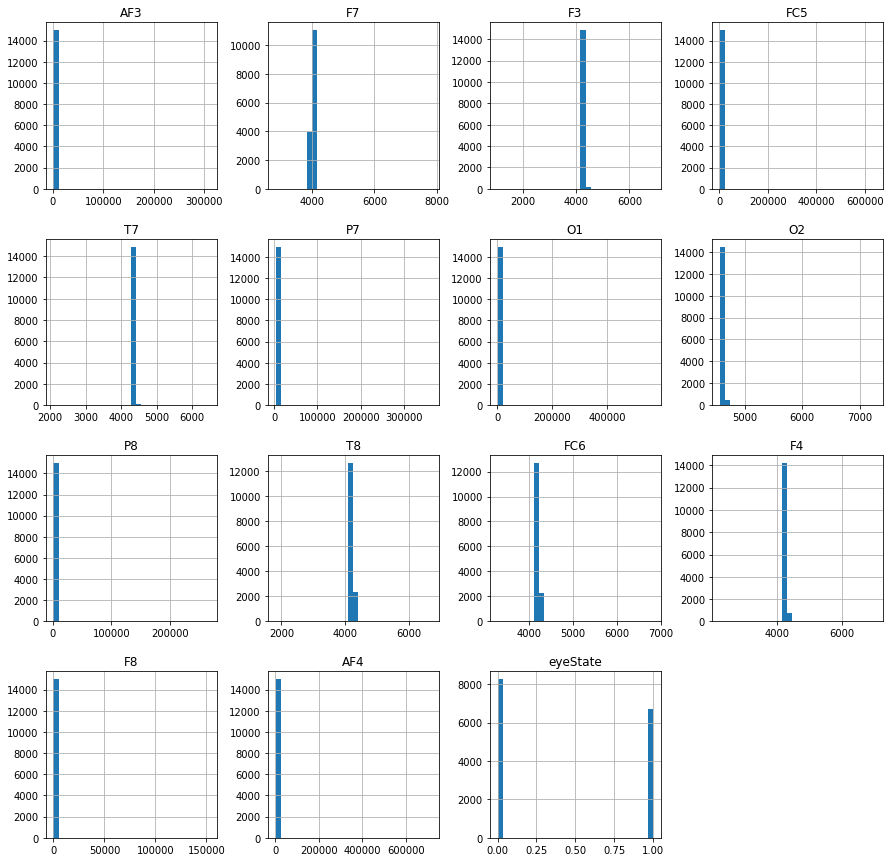

In [ ]:
data.hist(bins=30, figsize=(15,15))
plt.show()

We can see that every signal has a small variance. In section "Data Exploration" we found out that sensors "AF3", "FC5", "P7", "O1", "P8", "F8" and "AF4" have huge maximas in comparism to their general distribution. My prior hypothesis was that it might be linked to the eye state. I assumed that these high values occur when the eye is closed. Let's find out wether this hypothesis is true.

Focus on the relevant columns "AF3", "FC5", "P7", "O1", "P8", "F8", "AF4" and eyestate to test the hypothesis.

In [ ]:
data_red = data[["AF3", "FC5", "P7", "O1", "P8", "F8", "AF4", "eyeState"]]

data_open = data_red[data_red.eyeState == 0].copy()
data_closed = data_red[data_red.eyeState == 1].copy()

Let's look into their statistics.

In [ ]:
data_open.describe()

,AF3,FC5,P7,O1,P8,F8,AF4,eyeState
count,8257.000000,8257.000000,8257.000000,8257.000000,8257.000000,8257.000000,8257.000000,8257.0
mean,4298.402552,4200.391388,4664.726001,4140.387390,4200.367181,4600.899882,4456.567286,0.0
std,71.727033,7026.078621,3939.432964,6197.052117,48.380447,77.430622,7935.067845,0.0
min,1030.770000,2453.330000,2768.210000,3581.540000,1357.950000,86.666700,1366.150000,0.0
25%,4277.950000,4108.720000,4614.360000,4060.000000,4190.770000,4589.740000,4338.460000,0.0
50%,4291.280000,4121.030000,4619.490000,4070.770000,4199.490000,4601.030000,4352.310000,0.0
75%,4305.130000,4132.820000,4627.690000,4080.510000,4207.690000,4612.820000,4367.180000,0.0
max,7398.460000,642564.000000,362564.000000,567179.000000,7143.590000,4833.850000,715897.000000,0.0


In [ ]:
data_closed.describe()

,AF3,FC5,P7,O1,P8,F8,AF4,eyeState
count,6723.000000,6723.000000,6723.000000,6723.000000,6723.000000,6723.000000,6723.000000,6723.0
mean,4350.798517,4121.413696,4618.594772,4073.570684,4241.497964,4632.774892,4367.147507,1.0
std,3719.031369,26.527445,18.992404,34.213632,3188.564108,1801.617595,35.723321,0.0
min,4198.970000,4058.460000,4002.050000,2086.150000,4147.690000,4510.260000,4246.150000,1.0
25%,4284.100000,4107.180000,4608.720000,4055.380000,4190.515000,4592.310000,4346.150000,1.0
50%,4297.950000,4119.490000,4615.900000,4070.260000,4200.510000,4606.670000,4360.000000,1.0
75%,4317.950000,4131.790000,4624.100000,4088.720000,4211.790000,4623.080000,4380.000000,1.0
max,309231.000000,5416.410000,4708.720000,4167.180000,265641.000000,152308.000000,5022.560000,1.0


My hypothesis seems wrong because neither the maximum values cluster on either the open-eye or the closed-eye state nor is the dataset unbalanced (open eye: 8257, closed eye: 6723).

Nevertheless, we have to find out wether these values are systematically or just outliers.

### Outlierhandling

In this section i will remove each maximum of the unusual sensors ("AF3", "FC5", "P7", "O1", "P8", "F8", "AF4"). Afterwards i will check the effect by looking into the statistics. In addition to that i found out by visualizing in PCA section, that row 13179 is also an outlier. It will also be removed.

In [ ]:
outlier_df = data[(data.AF3==309231.0) |
            (data.FC5==642564.0) |
            (data.P7==362564.0) |
            (data.O1==567179.0) |
            (data.P8==265641.0) |
            (data.F8==152308.0) |
            (data.AF4==715897.0)]
outlier_df = pd.concat([outlier_df, data[data.index == 13179]])
outlier_df

,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4,eyeState
898,7222.05,3797.95,1040.00,3733.85,6040.51,362564.00,6350.26,5361.54,1357.95,6215.38,3273.33,3091.28,276.4100,715897.00,0
10386,7398.46,2830.77,2457.44,642564.00,6474.36,8092.31,567179.00,5087.69,7143.59,1816.41,6137.95,6904.62,3504.1000,121026.00,0
11509,309231.00,5500.51,6880.51,5416.41,5454.87,4002.05,2086.15,4770.26,265641.00,3914.87,6823.08,2257.95,152308.0000,5022.56,1
13179,1030.77,7804.62,5762.56,2453.33,2089.74,2768.21,3581.54,7264.10,4586.15,6674.36,5170.77,7002.56,86.6667,1366.15,0


As you can see these 7 outliers are clustered in 3 measurements. Due to their distance to the general distribution and their little occurence (3 measurements of total 14980) i remove them to avoid learning from outliers. 

In [ ]:
data = data[~np.isin(data.index, outlier_df.index)]
data.shape

(14976, 15)

Check for further outliers.

In [ ]:
data.describe()

,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4,eyeState
count,14976.000000,14976.000000,14976.000000,14976.000000,14976.000000,14976.000000,14976.000000,14976.000000,14976.000000,14976.000000,14976.000000,14976.000000,14976.000000,14976.000000,14976.000000
mean,4301.378607,4009.507626,4264.083569,4122.377696,4341.561287,4620.060675,4072.823013,4615.788517,4201.341742,4231.202968,4202.150055,4279.089914,4606.009665,4361.304558,0.448851
std,37.770271,30.087356,21.335365,20.929477,17.007343,18.517252,20.910175,18.341333,17.841047,19.765889,24.475270,20.093956,33.405176,38.472996,0.497394
min,4197.950000,3905.640000,4197.440000,4058.460000,4304.620000,4566.150000,4026.150000,4567.180000,4147.690000,4152.820000,4100.000000,4201.030000,4443.080000,4205.640000,0.000000
25%,4280.510000,3990.770000,4250.260000,4108.210000,4331.790000,4611.790000,4057.950000,4604.620000,4190.770000,4220.510000,4190.260000,4267.690000,4590.770000,4342.050000,0.000000
50%,4294.360000,4005.640000,4262.560000,4120.510000,4338.970000,4617.950000,4070.260000,4613.330000,4199.490000,4229.230000,4200.510000,4276.920000,4603.080000,4354.870000,0.000000
75%,4311.790000,4023.080000,4270.770000,4132.310000,4347.180000,4626.670000,4083.590000,4624.100000,4209.230000,4239.490000,4211.280000,4287.180000,4617.440000,4372.820000,1.000000
max,4504.100000,4156.920000,4386.150000,4250.260000,4463.590000,4756.920000,4178.460000,4731.790000,4320.000000,4362.560000,4332.310000,4397.950000,4833.850000,4573.330000,1.000000


### Cleaned data visualization

All outliers are treated. Now i will gather an insight on the specific distribution of every sensor for open and closed eye state.

In [ ]:
def plot_open_closed_data(dataX_open, dataX_closed):
  def trim_axs(axs, N):
      """
      Reduce *axs* to *N* Axes. All further Axes are removed from the figure.
      """
      axs = axs.flat
      for ax in axs[N:]:
          ax.remove()
      return axs[:N]

  colLabels = dataX_open.columns

  sns.set(style="darkgrid")

  fig, axs = plt.subplots(4, 4, figsize=(18,18))
  axs = trim_axs(axs, len(dataX_open.columns))

  for ax, colLabel in zip(axs, data.columns):
    sns.histplot(data=dataX_open, x=colLabel, bins=30, color="skyblue", label="Open", kde=True, ax=ax)
    sns.histplot(data=dataX_closed, x=colLabel, bins=30, color="red", label="Closed", kde=True, ax=ax)

    ax.legend() 
  fig.tight_layout()
  plt.show()
  return

In [ ]:
data_open = data[data.eyeState == 0].copy()
data_closed = data[data.eyeState == 1].copy()

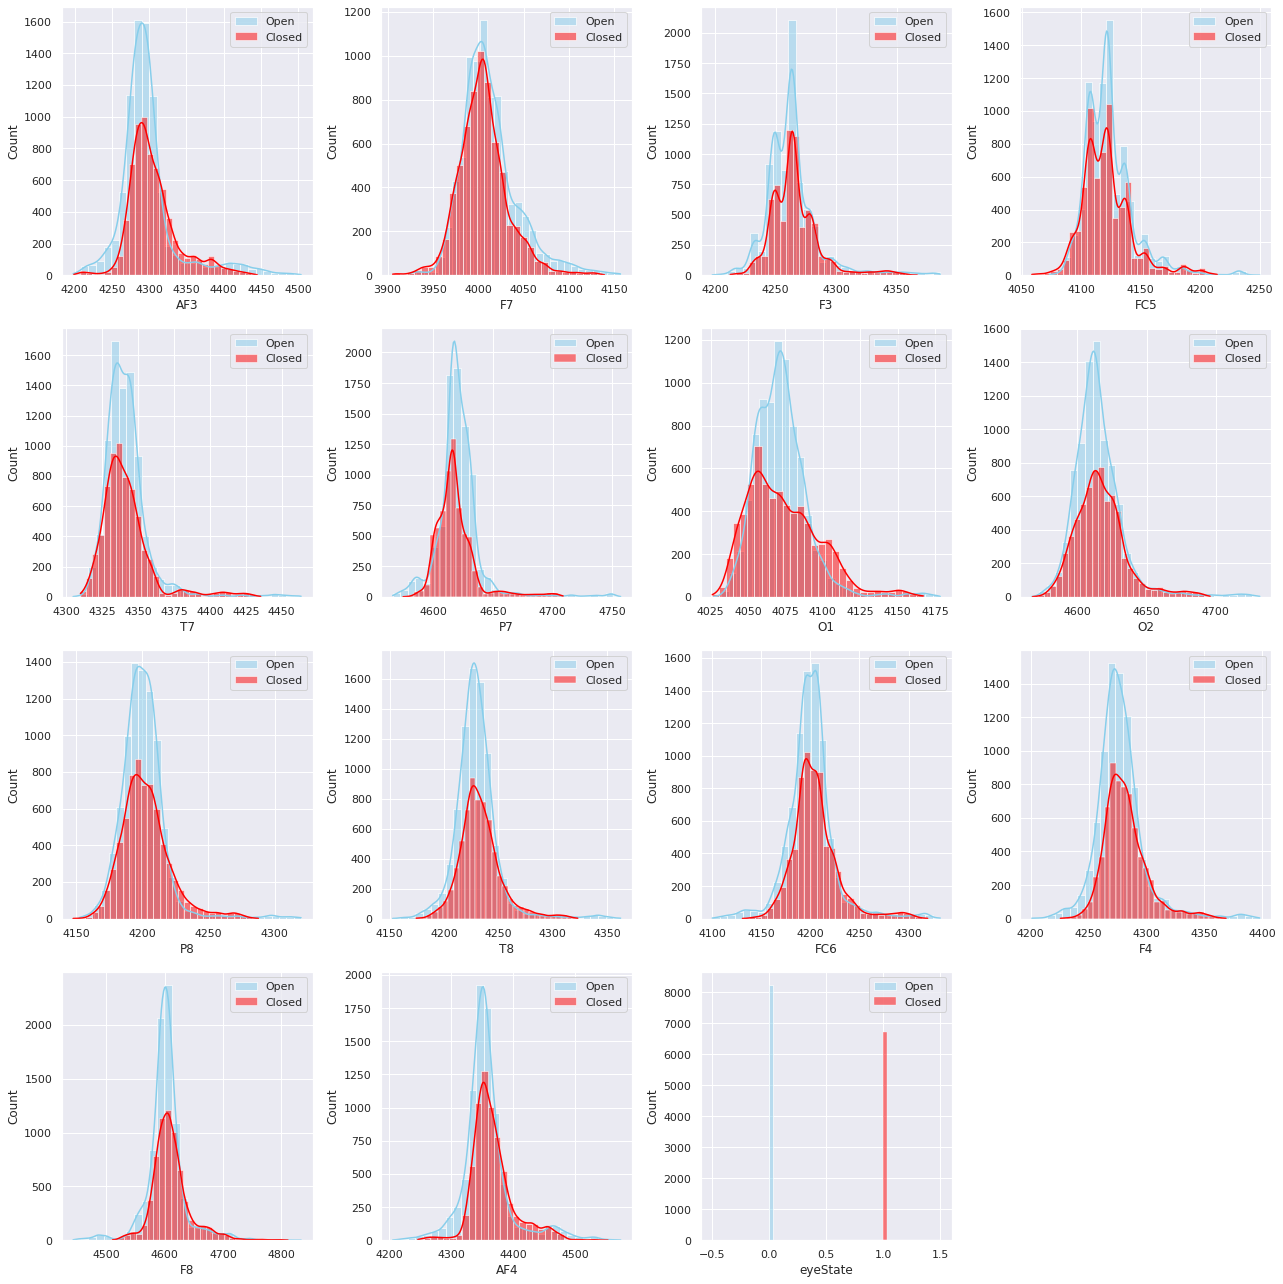

In [ ]:
plot_open_closed_data(data_open, data_closed)

The visualized data looks much better now. You can get a much more detailled view on the outlier treated columns. 

Overall the data quality is very good because there aren't any missing values and the outliers clearly separated from the normal data and have an almost vanishing occurence. Most of the signals are normally distributed with just small differences between eyeState open and eyeState closed.

## Creating the Feature Matrix and Labels

In [ ]:
dataX = data.copy().drop(['eyeState'],axis=1)
dataY = data['eyeState'].astype(int).copy()
dataY.value_counts()

0    8254
1    6722
Name: eyeState, dtype: int64

## Feature Standardization: Rescaling the Data

Some classifiers or ML algorithms require standarized features (µ=0, std=1). Otherwise features with a wider spread are seen as more important. Hence, we have to standardize every feature before we can create the classifier.

In [ ]:
def rescale_data(dataX):
  #Rescaling the data
  featuresToScale = dataX.columns
  sX = pp.StandardScaler(copy=True)
  dataX.loc[:,featuresToScale] = sX.fit_transform(dataX[featuresToScale])
  return dataX

In [ ]:
dataX = rescale_data(dataX)
#Looking into the statistics again:
dataX.describe()

,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4
count,1.497600e+04,1.497600e+04,1.497600e+04,1.497600e+04,1.497600e+04,1.497600e+04,1.497600e+04,1.497600e+04,1.497600e+04,1.497600e+04,1.497600e+04,1.497600e+04,1.497600e+04,1.497600e+04
mean,4.627857e-15,-1.019461e-15,-3.082155e-16,-2.966698e-15,-1.709204e-14,1.260361e-14,3.075731e-15,1.964635e-14,3.136403e-14,-1.359408e-14,1.087056e-14,-1.809685e-14,1.171336e-14,-1.930918e-15
std,1.000033e+00,1.000033e+00,1.000033e+00,1.000033e+00,1.000033e+00,1.000033e+00,1.000033e+00,1.000033e+00,1.000033e+00,1.000033e+00,1.000033e+00,1.000033e+00,1.000033e+00,1.000033e+00
min,-2.738452e+00,-3.452317e+00,-3.123724e+00,-3.054058e+00,-2.172151e+00,-2.911473e+00,-2.232146e+00,-2.650306e+00,-3.007308e+00,-3.965700e+00,-4.173742e+00,-3.884876e+00,-4.877541e+00,-4.046208e+00
25%,-5.525325e-01,-6.227949e-01,-6.479397e-01,-6.769481e-01,-5.745526e-01,-4.466619e-01,-7.113049e-01,-6.089465e-01,-5.925714e-01,-5.409989e-01,-4.858150e-01,-5.673494e-01,-4.562219e-01,-5.004861e-01
50%,-1.858298e-01,-1.285508e-01,-7.141288e-02,-8.924058e-02,-1.523679e-01,-1.139881e-01,-1.225766e-01,-1.340469e-01,-1.037946e-01,-9.982015e-02,-6.701091e-02,-1.079920e-01,-8.770387e-02,-1.672543e-01
75%,2.756597e-01,4.511140e-01,3.134071e-01,4.745764e-01,3.303809e-01,3.569399e-01,5.149334e-01,4.531710e-01,4.421557e-01,4.192733e-01,3.730398e-01,4.026263e-01,3.421840e-01,2.993223e-01
max,5.367400e+00,4.899643e+00,5.721510e+00,6.110357e+00,7.175300e+00,7.391156e+00,5.052111e+00,6.324805e+00,6.651079e+00,6.645864e+00,5.318196e+00,5.915413e+00,6.820738e+00,5.511204e+00


## Correlations

To gather in insight on the correlations in my data i'm going to create a correlation matrix.

$Corr(a,b) = \frac{\frac{1}{(n-1)}*\sum_{i=1} ^{n} [(a_i - \bar{a})*(b_i - \bar{b})]}{\sigma_a * \sigma_b}$

The correlation coefficient describes the relationship of two features and ranges from -1 to 1. Two features have a positive correlation coefficient if feature B increases after feature A has been increased. They have a negative correlation coefficient if the feature B decreases after A has been increased.

In [ ]:
correlationMatrix = pd.DataFrame(dataX).corr() 

#f = plt.figure(figsize=(12, 6))
#plt.matshow(correlationMatrix, fignum=f.number)
#plt.xticks(range(dataX.shape[1]), dataX.columns, fontsize=14, rotation=75)
#plt.yticks(range(dataX.shape[1]), dataX.columns, fontsize=14)
#cb = plt.colorbar()
#cb.ax.tick_params(labelsize=14)
correlationMatrix.style.background_gradient(cmap='viridis').set_precision(2)

,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4
AF3,1.00,0.59,0.76,0.61,0.35,0.23,0.32,0.22,0.32,0.50,0.65,0.80,0.76,0.94
F7,0.59,1.00,0.57,0.75,0.49,0.33,0.26,0.11,0.14,0.18,0.25,0.38,0.25,0.41
F3,0.76,0.57,1.00,0.77,0.64,0.60,0.49,0.55,0.56,0.64,0.67,0.83,0.62,0.71
FC5,0.61,0.75,0.77,1.00,0.68,0.54,0.40,0.36,0.37,0.40,0.41,0.56,0.36,0.47
T7,0.35,0.49,0.64,0.68,1.00,0.83,0.66,0.66,0.64,0.63,0.53,0.53,0.36,0.30
P7,0.23,0.33,0.60,0.54,0.83,1.00,0.66,0.72,0.71,0.65,0.50,0.51,0.31,0.21
O1,0.32,0.26,0.49,0.40,0.66,0.66,1.00,0.64,0.67,0.57,0.51,0.58,0.39,0.33
O2,0.22,0.11,0.55,0.36,0.66,0.72,0.64,1.00,0.87,0.72,0.59,0.59,0.41,0.29
P8,0.32,0.14,0.56,0.37,0.64,0.71,0.67,0.87,1.00,0.83,0.68,0.67,0.54,0.39
T8,0.50,0.18,0.64,0.40,0.63,0.65,0.57,0.72,0.83,1.00,0.80,0.76,0.71,0.59


The correlation matrix highlights that electrodes that are located close to each other (e.g. AF3 and AF4) correlate with each other in general. On the other side it highlights that F7 and F8, which are located on opposite sides, have a low positive correlation.

## Train test split

In order to create a classification model we have to train it on some data. This trained model will then be tested on the test data which it has never seen before. 
Since there's no optimal testsize i chose 25%.


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    dataX, 
    dataY, test_size=0.25,
    random_state=2022, stratify=dataY)  

## Cross-Validation

To maximize the generalization of the trained model i will use *Cross-Validation*. The alternative approach is *Bootstrapping*. *Bootstrapping* is useful for small datasets (#samples < 300), but this one has a large amount of samples and hence i choose *Cross-Validation*.

*Cross-Validation* divides the *training data* in k batches and trains the model on k-1 of these batches. After that the trained model will be tested on the kth. I chose 10 splits since this is the normal amount according to the lecture notes.

In [ ]:
k_fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=2022)

## Calculate the model performance

Let's assume we have two trained models (different algorithms or same algorithm with different hyperparameters). *How do we decide which model is better?*
There are a lot of methods to calculate the model performance, but no method is suitable in every case. Some metrics for classifiers are:


*   __[Log loss](https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a)__: This score is especially useful in multiclass classifications __[[1]](https://towardsdatascience.com/metrics-to-evaluate-your-machine-learning-algorithm-f10ba6e38234)__.
*   __[Confusion matrix](https://towardsdatascience.com/understanding-confusion-matrix-a9ad42dcfd62)__: The confusion matrix is the basis on which a variety of evaluation scores build on. These are:
  *   __[Receiver operating curve (ROC)](https://towardsdatascience.com/metrics-to-evaluate-your-machine-learning-algorithm-f10ba6e38234)__: This score is used for **balanced** datasets. Scores like Area under curve (AUC), which is one of the most widely used scores for binary classifiers, can be calculated based on it __[[2]](https://towardsdatascience.com/metrics-to-evaluate-your-machine-learning-algorithm-f10ba6e38234)__.
  *   __[Precision-Recall curve](https://deepai.org/machine-learning-glossary-and-terms/precision-and-recall)__: This score is used for **imbalanced** datasets.

Further metrics can be found __[here](https://scikit-learn.org/stable/modules/model_evaluation.html)__.

My dataset is balanced (6722 entrys with eyeState open and 8255 entrys with eyeState closed). Hence, i will choose the ROC score to evaluation my classifier performance. In addition to that, i will also use the LogLoss for further comparisms.


# Testing Phase I: Baseline Models

In this section i will test different basic models and compare them with each other. The models i used are:

*  Logistic Regression
*  Support Vector Machine
*  K-Nearest Neighbours
*  Random Forest

In [ ]:
evaluationDF = pd.DataFrame(index=["LogReg", "SVC", "KNN", "RandomForest"],
                            columns=["TrainingLogLossCV", "TrainingAUC",
                                     "TestLogLossCV", "TestAUC", "ComputationTimeTestData"])

## Dimensionality Reduction

According to the lecture dimensionality reduction has three usecases:


1.   Data preprocessing for more efficient computing
2.   Feature extraction -> pattern recognition
3.   Visualization


As stated in the Project Template i have a highdimensional dataset which needs a dimensionality reduction via PCA or clustering. To check the impact of the use of PCA on the performance results i kept 8 dimensions. The results are shown in section *Overall comparism*. In this section i faced the 3rd usecase Visualization to gather an insight on how mixed the data is.

In [ ]:
# Whitening will remove some information from the transformed signal
# but can sometime improve the predictive accuracy of the downstream estimators. 
whiten = True
#If auto, the solver is selected by a default policy based on X.shape and n_components:
svd_solver = 'auto'
#Random state for reproducibility:
random_state = 2021

pca = PCA(whiten=whiten, svd_solver = svd_solver, random_state=random_state)

In [ ]:
def fit_pca(X, pca):
  # Model Implementation:

  #Fit the model with X and apply the dimensionality reduction on X
  X_PCA = pca.fit_transform(X)
  # Organizing the data:
  X_PCA = pd.DataFrame(data=X_PCA, index=X.index)

  return X_PCA

In [ ]:
X_train_PCA = fit_pca(X_train, pca)

#Transform data back to its original space:
X_train_PCA_inverse = pca.inverse_transform(X_train_PCA)
# Organizing the data:
X_train_PCA_inverse = pd.DataFrame(data=X_train_PCA_inverse, index=X_train.index)

In [ ]:
# Variance ratio explained by each of the selected components
print(pca.explained_variance_ratio_)
for i in range(3, len(X_train.columns)+1):
  print(f"The first {i} dimensions contain ", np.round(sum(pca.explained_variance_ratio_[0:i])*100, 2), "% of the overall variance.")

[0.59923077 0.15179368 0.11014831 0.03180288 0.02329341 0.01933504
 0.01280572 0.01208413 0.01006166 0.0090353  0.0071248  0.00634699
 0.005099   0.00183832]
The first 3 dimensions contain  86.12 % of the overall variance.
The first 4 dimensions contain  89.3 % of the overall variance.
The first 5 dimensions contain  91.63 % of the overall variance.
The first 6 dimensions contain  93.56 % of the overall variance.
The first 7 dimensions contain  94.84 % of the overall variance.
The first 8 dimensions contain  96.05 % of the overall variance.
The first 9 dimensions contain  97.06 % of the overall variance.
The first 10 dimensions contain  97.96 % of the overall variance.
The first 11 dimensions contain  98.67 % of the overall variance.
The first 12 dimensions contain  99.31 % of the overall variance.
The first 13 dimensions contain  99.82 % of the overall variance.
The first 14 dimensions contain  100.0 % of the overall variance.


### Visualization of 3 main PCA components

In [ ]:
df = pd.DataFrame(data=X_train_PCA.loc[:,0:2], index=X_train_PCA.index)
df.columns = ["First Dimension", "Second Dimension", "Third Dimension"]
df["Label"] = [str(label) for label in list(y_train)] #convert labels to string for discrete colors
df.reset_index(drop=False, inplace=True)
df.head()

,index,First Dimension,Second Dimension,Third Dimension,Label
0,11472,0.446766,-1.474755,0.509611,1
1,6914,-0.811721,-1.470305,1.577089,1
2,14481,-1.098380,-0.845184,-0.721976,0
3,9002,-0.020534,0.706179,-1.135326,1
4,2167,0.286057,3.544659,0.336471,0


In [ ]:
fig = px.scatter_3d(df, x="First Dimension", y="Second Dimension", z="Third Dimension", color="Label", hover_data=["index"])
fig.show()

### Feature reduction

In a scenario where the current algorithm training performance is too bad and has to be improved it is useful to use atleast 8 features since it is common to use +95% of overall variance to train the algorithms.



```
reduce_features = False
if reduce_features==True:
  number_of_kept_dimensions = 8

  X_train = X_train_PCA.iloc[:, :number_of_kept_dimensions].copy()
  X_test = fit_pca(X_test, pca).iloc[:, :8].copy()
```




## Cost function

During the algorithm training process it will try to improve, but how does the algorithm know how good it currently performs? 
In order to give the algorithm a quantitative measurement of its current performance we have to define a cost function which the algorithm will try to minimize to improve the model performance. 

As in the lecture i am dealing with a binary classification problem and therefore, i will also choose binary classification **log loss**.

In [ ]:
def calculateLogLossCV(model, X_train, y_train, show_output=False):
  
  #lists for storing scores
  trainingScores = []
  cvScores = [] 

  predictionsBasedOnKFolds = pd.DataFrame(data=[], index=y_train.index,columns=[0,1])

  #kfold the X-data 
  for train_index, cv_index in k_fold.split(np.zeros(len(X_train)), y_train.ravel()):

    #gather data of current cv fraction based in indices
    X_train_fold, X_cv_fold = X_train.iloc[train_index,:], X_train.iloc[cv_index,:]
    y_train_fold, y_cv_fold = y_train.iloc[train_index], y_train.iloc[cv_index]

    #fit model in gathered data
    model.fit(X_train_fold, y_train_fold)

    #calculate logloss of training data
    loglossTraining = log_loss(y_train_fold, model.predict_proba(X_train_fold)[:,1])
    #Saving our analysis on the list:
    trainingScores.append(loglossTraining)

    #calculate logloss of cv test data (not overall test data)
    predictionsBasedOnKFolds.loc[X_cv_fold.index,:] = model.predict_proba(X_cv_fold)
    loglossCV = log_loss(y_cv_fold, predictionsBasedOnKFolds.loc[X_cv_fold.index,1])
    #Saving our analysis on the list:
    cvScores.append(loglossCV)

    #printing the results:
    if show_output == True:
      print('Training Log Loss: ', loglossTraining)
      print('CV Log Loss: ', loglossCV)
      print()

  #Lets see the overall log loss for the entire training set
  overallLogLoss = log_loss(y_train, predictionsBasedOnKFolds.loc[:,1])
  if show_output == True:
    print('------------------------')
    print(f'Overall log loss: ', overallLogLoss)

  return overallLogLoss, predictionsBasedOnKFolds

## Model Evaluation

In binary classification tasks it is common to visualize the results via the confusion matrix.
Based on the confusion matrix the ROC Curve and AUC can be calculated. 

*  Basic interpretation for ROC: the more top left the red line, the better the classifier. 
*  Basic interpretation for AUC: The greater the value (max: 1) the better the classifier. It's a metric to easily compare multiple ROC curves.

In [ ]:
def evaluateModel(model, X, y, y_preds, show_plots = True):
  if show_plots==True:
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))
    fig.tight_layout()
    fig.subplots_adjust(wspace=0.5)

    #confusion matrix
    ax1.grid(False)
    plot_confusion_matrix(model, X, y, ax=ax1)

  #ROC
  preds = pd.concat([y, y_preds.loc[:,1]], axis=1)
  preds.columns = ['trueLabel','prediction']

  fpr, tpr, thresholds = roc_curve(preds['trueLabel'],preds['prediction'])
  areaUnderROC = auc(fpr, tpr)
  if show_plots==True:
    plt.axes(ax2) #change active axes
    plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: Area under the curve = {0:0.2f}'.format(areaUnderROC))
    plt.legend(loc="lower right")
    plt.show()

  return areaUnderROC

In [ ]:
def evaluateModelOnTestData(model, X_test, y_test, modelname):

  start = time.time()
  predictionsTestSet = pd.DataFrame(data=[],index=y_test.index,columns=[0,1])

  predictionsTestSet.loc[X_test.index,:] = model.predict_proba(X_test)
  logLossTestSet = log_loss(y_test, predictionsTestSet.loc[X_test.index,1])

  end = time.time()

  print(f'Log loss of {modelname} model: ', logLossTestSet)

  #show confusion matrix and ROC
  areaUnderROC = evaluateModel(model, X_test, y_test, predictionsTestSet)

  return areaUnderROC, logLossTestSet, np.round(end-start,2)

## Logistic Regression

Model initialization:
I tuned the hyperparameters via GridSearch using

  > 

```
tuned_params = pd.DataFrame(index=["liblinear", "saga", "sag"], columns=["params", "score"])
Cs = np.logspace(-5, 5, 11)
grid1={"C":Cs, "penalty":["l1", "l2"], "solver":["liblinear"]}
grid2={"C":Cs, "penalty":["l1", "l2", "elasticnet"], "solver":["saga"]}
grid3={"C":Cs, "penalty":["l2"], "solver":["sag"]}

for i,grid in enumerate([grid1, grid2, grid3]):
  logReg=LogisticRegression()
  logReg_cv=GridSearchCV(logReg, grid, cv=3, scoring="neg_log_loss")
  logReg_cv.fit(X_train,y_train)

  tuned_params["params"].iat[i] = logReg_cv.best_params_
  tuned_params["score"].iat[i] = logReg_cv.best_score_

tuned_params
```


Which returned

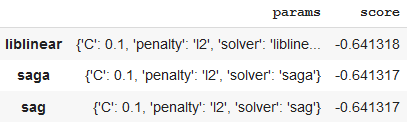

The score is negative due to the used metric. I had to use neg_log_loss because GridSearchCV tries to *maximize* the cost function, but a smaller log_loss is better. 

In [ ]:
# Hyperparameters:
penalty = 'l2'
C = 0.1 #regularization strength. The smaller the value, the stronger the regularization. 
# Regularization is used to avoid overfitting.
random_state = 2022
solver = 'liblinear'
logReg = LogisticRegression(penalty=penalty, C=C, random_state=random_state, solver=solver)

Evaluation:

In [ ]:
overallLogLoss, predictionsBasedOnKFolds = calculateLogLossCV(logReg, X_train, y_train, show_output=False)
evaluationDF["TrainingLogLossCV"].loc["LogReg"] = overallLogLoss

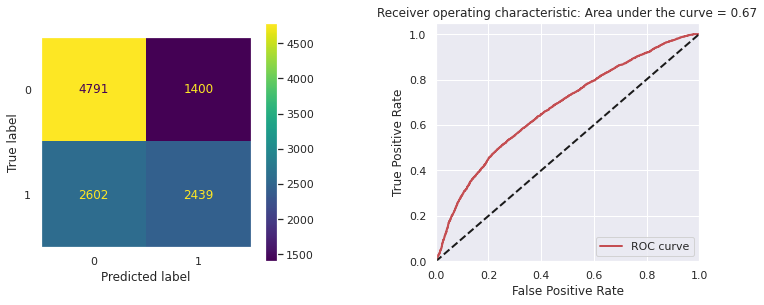

In [ ]:
evaluationDF["TrainingAUC"].loc["LogReg"] = evaluateModel(logReg, X_train, y_train, predictionsBasedOnKFolds)

## Support Vector Machine

I use the __[linear kernel](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)__ adaption of SVM because it scales better with the quantity of examples.

Model Initialization:
I optimized the SVM via 



```
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
C = np.logspace(0, 3, 10)

grid = {'kernel': kernels,'C':C}

gridSearch = GridSearchCV(SVC, grid, scoring="neg_log_loss", cv=5, refit=True)
gridSearch.fit(X_train, y_train)
results = gridSearch.cv_results_
```


For further analysis i use the optimized parameters.

In [ ]:
C=1.0
kernel='linear' #used to imitate LinearSVC with probability. Runs longer than linearSVC.
# support in order to compare results with other algorithms via log_loss
shrinking=True #improves training time if tol isn't too large.


#inserting parameters in model:
SVC = SVC(C=C, kernel=kernel, shrinking=shrinking, random_state=2021, probability=True)

Evaluation:

In [ ]:
overallLogLoss, predictionsBasedOnKFolds = calculateLogLossCV(SVC, X_train, y_train, show_output=True)
evaluationDF["TrainingLogLossCV"].loc["SVC"] = overallLogLoss

Training Log Loss:  0.6436481028703958
CV Log Loss:  0.631431124206259

Training Log Loss:  0.6425746906169794
CV Log Loss:  0.6517110277362065

Training Log Loss:  0.6432720890429889
CV Log Loss:  0.6472302533433123

Training Log Loss:  0.6425039287139457
CV Log Loss:  0.6527762263796051

Training Log Loss:  0.6428840528116172
CV Log Loss:  0.6503172999365442

Training Log Loss:  0.6433917662602259
CV Log Loss:  0.6419889412605161

Training Log Loss:  0.644815475624702
CV Log Loss:  0.6326017340857633

Training Log Loss:  0.6420396006102801
CV Log Loss:  0.655663232765459

Training Log Loss:  0.6424494111873575
CV Log Loss:  0.6481050354036124

Training Log Loss:  0.6447062805964836
CV Log Loss:  0.6338619135572275

------------------------
Overall log loss:  0.644568145106251


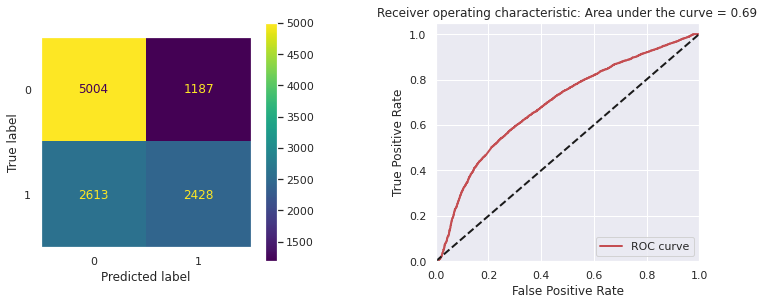

In [ ]:
evaluationDF["TrainingAUC"].loc["SVC"] = evaluateModel(SVC, X_train, y_train, predictionsBasedOnKFolds)

## K-Nearest Neighbour

Determined best number of neighbours via

```
neighbours = np.arange(1, 20)
df = pd.DataFrame(index=neighbours, columns=["logLoss"])
for n in neighbours:
  df["logLoss"].at[n], _ = calculateLogLossCV(KNeighborsClassifier(n_neighbors=n), X_train, y_train, show_output=False)

df.reset_index(drop=False, inplace=True)
df.rename(columns = {"index":"n_neighbours"}, inplace = True)
fig = px.line(df, x="n_neighbours", y="logLoss", title='logLoss for different number of neighbours')
fig.show()
```

which returns
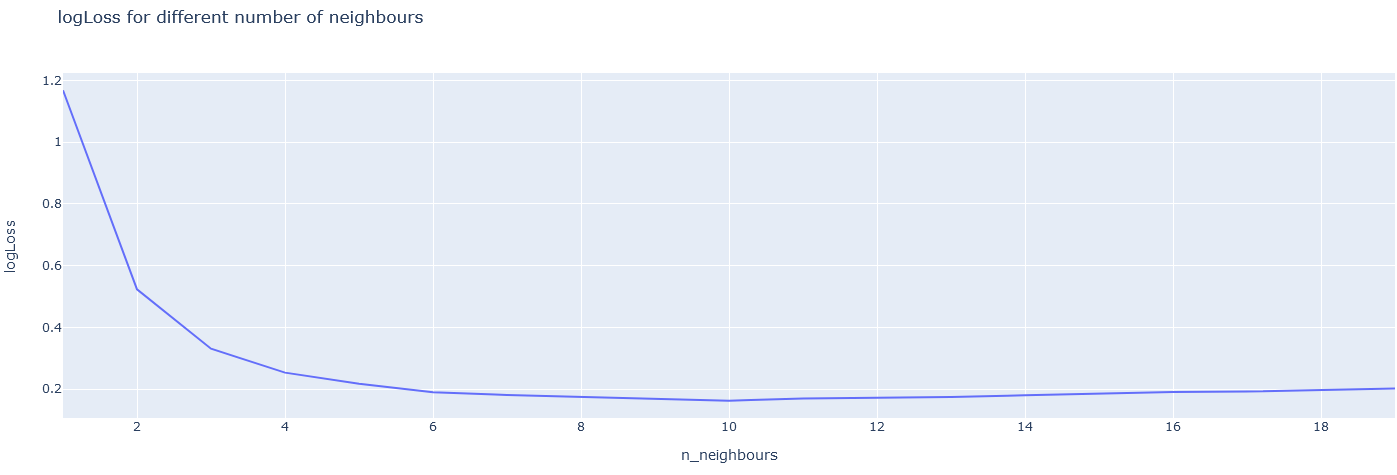

The curves elbow is at n=10. Hence, i choose 10 as my number of nearest neighbours.

In [ ]:
knn_tuned = KNeighborsClassifier(n_neighbors=10)
overallLogLoss, predictionsBasedOnKFolds = calculateLogLossCV(knn_tuned, X_train, y_train, show_output=True)
evaluationDF["TrainingLogLossCV"].loc["KNN"] = overallLogLoss

Training Log Loss:  0.12367043225847385
CV Log Loss:  0.17957460502518652

Training Log Loss:  0.12431779932019595
CV Log Loss:  0.1527788386988547

Training Log Loss:  0.12312210791111672
CV Log Loss:  0.20719918498244166

Training Log Loss:  0.1245683863227889
CV Log Loss:  0.14774433841866402

Training Log Loss:  0.12362374486949124
CV Log Loss:  0.18267822697946837

Training Log Loss:  0.12445635804647681
CV Log Loss:  0.1499411935749501

Training Log Loss:  0.12419099783069637
CV Log Loss:  0.1512881433587522

Training Log Loss:  0.12450914529633864
CV Log Loss:  0.1491337761209424

Training Log Loss:  0.1236357047241729
CV Log Loss:  0.14842724512427477

Training Log Loss:  0.12438159445136086
CV Log Loss:  0.15290154924055668

------------------------
Overall log loss:  0.16216742418583321


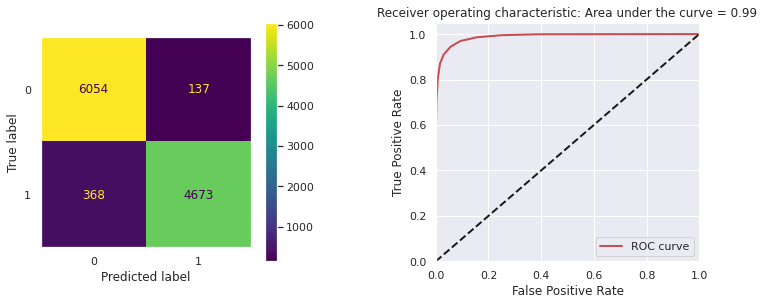

In [ ]:
evaluationDF["TrainingAUC"].loc["KNN"] = evaluateModel(knn_tuned, X_train, y_train, predictionsBasedOnKFolds)

This model has a very high TP and TN rate and is very promising!

## Random Forest

I implemented a custom GridSearchCV to optimize the parameters of the RandomForestClassifier. The general area of optimal parameters can be found with RandomizedSearchCV.



```
logLossLs = []
aucLs = []
times = []
n_estimatorsLs = []
max_depthLs = []
for n_estimators in [100, 125, 150, 175, 200, 225, 250, 275, 300]:
  for max_depth in np.arange(15, 25):

    start = time.time()

    #create model with tuned hyperparameters
    RandomForest = RandomForestClassifier(max_depth=max_depth, n_estimators=n_estimators, random_state=2021)

    #fit, predict and calculate score of model
    overallLogLoss, predictionsBasedOnKFolds = calculateLogLossCV(RandomForest, X_train, y_train, show_output=False)

    stop = time.time()
    logLossLs.append(overallLogLoss)
    aucLs.append(evaluateModel(RandomForest, X_train, y_train, predictionsBasedOnKFolds, show_plots=False))
    times.append(np.round(stop-start,2))
    n_estimatorsLs.append(n_estimators)
    max_depthLs.append(max_depth)
    
```



```
pd.DataFrame({"NumberOfTrees": n_estimatorsLs,
              "MaxDepthOfTree": max_depthLs,
              "TrainingLogLossCV": logLossLs,
              "TrainingAUC": aucLs,
              "ComputationTime": times})
```

Which returned

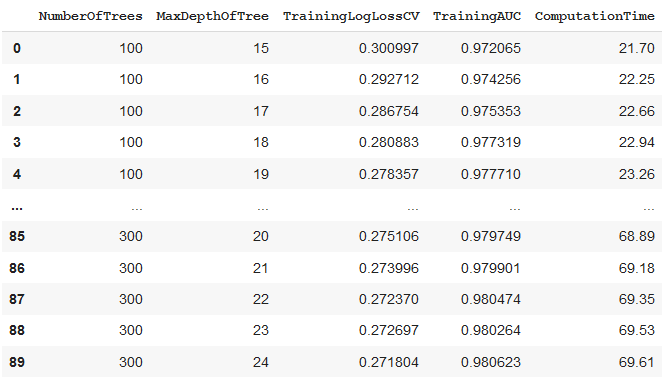

As you can see there's no major benefit of a large number of trees, so i tried a lower number of trees with a greater depth.

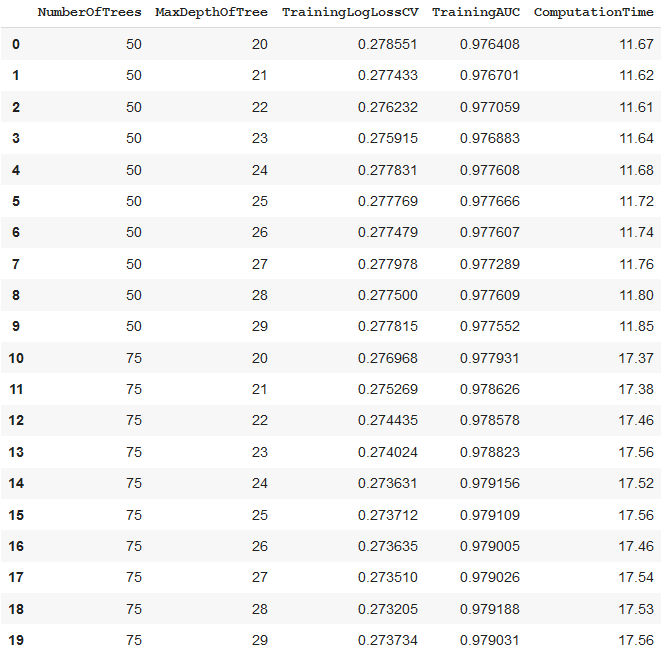

I chose max_depth=29 and n_estimators=50 because it leads to similar results as the more complex architectures without an improvement in neither Log loss score nor AUC. I could also perform a finer search around 50, but it looks like all the architectures i have analyzed perform equally well.

In [ ]:
#create model with tuned hyperparameters
RandomForest = RandomForestClassifier(max_depth=29, n_estimators=50, random_state=2021)

#fit, predict and calculate score of model
overallLogLoss, predictionsBasedOnKFolds = calculateLogLossCV(RandomForest, X_train, y_train, show_output=True)
evaluationDF["TrainingLogLossCV"].loc["RandomForest"] = overallLogLoss

Training Log Loss:  0.08688714327498695
CV Log Loss:  0.2731354667469346

Training Log Loss:  0.08614803763550848
CV Log Loss:  0.2802804285591975

Training Log Loss:  0.08572625841175058
CV Log Loss:  0.2821094103751469

Training Log Loss:  0.08602877033275488
CV Log Loss:  0.28504215858945825

Training Log Loss:  0.0862194679980903
CV Log Loss:  0.2751025523067905

Training Log Loss:  0.08640337181762316
CV Log Loss:  0.2784305504758984

Training Log Loss:  0.08634703100453904
CV Log Loss:  0.27774883150935153

Training Log Loss:  0.08570602040338712
CV Log Loss:  0.26945161841396015

Training Log Loss:  0.08718894190216883
CV Log Loss:  0.2594324695279336

Training Log Loss:  0.0853952659967337
CV Log Loss:  0.2974180398843303

------------------------
Overall log loss:  0.2778149554870153


Although i might have a little overfitting  due to the difference of trainingLogLoss and CVlogLoss i get quite good results later and therefore i will stick to my architecture. In general it is unlikely that a RandomForestClassifier overfits because it consists of many weak learners which hardly overfit.

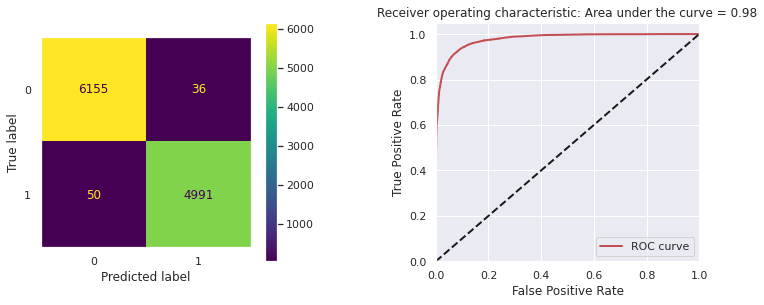

In [ ]:
evaluationDF["TrainingAUC"].loc["RandomForest"] = evaluateModel(RandomForest, X_train, y_train, predictionsBasedOnKFolds)

Check feature importance 

In [ ]:
pred_comp = RandomForest.fit(X_train, y_train)
for name, score in zip(X_train.columns, pred_comp.feature_importances_):
    print(f'{name}, {np.round(score*100, 2)}%')

AF3, 7.53%
F7, 9.38%
F3, 5.38%
FC5, 6.08%
T7, 5.38%
P7, 10.71%
O1, 11.9%
O2, 5.69%
P8, 4.43%
T8, 5.69%
FC6, 6.07%
F4, 6.12%
F8, 8.17%
AF4, 7.46%


## Overall comparism

In this section i compare the performance of every implemented algorithm so far by evaluating its performance on the test data (X_test, y_test).

### Comparism of different ML Models

**Naive classifier**

Before i start implementing the algorithms i want to calculate whats a good log loss on the test data. In other words: Which Log loss do i have to beat in order to outperform the naive guess (always 0 or always 1). 
To do so i will calculate it manually according to:


$$Log Loss = -\frac{1}{N_{positive} + N_{negative}}(\sum_{n=1}^{N_{positive}} log(p(y_i)) + \sum_{n=1}^{N_{negative}} log(1-p(y_i)))$$

where $$p(y_i)$$ is calculated from the training data.



In [ ]:
#calculate probabilities of a positive (eye closed) example in training data
N_pos_train = y_train.value_counts()[0]
N_neg_train = y_train.value_counts()[1]

#probability of eyes open in training data
p = N_pos_train/(N_pos_train+N_neg_train)

#get number of positive and negative examples in test data
N_pos_test = y_test.value_counts()[0]
N_neg_test = y_test.value_counts()[1]

#Calculate logLoss
BaselineLogLoss = -1/(N_pos_test+N_neg_test)*(N_pos_test*math.log(p)+N_neg_test*math.log(1-p))
print(f"The logloss baseline to beat is {BaselineLogLoss}.")

The logloss baseline to beat is 0.6879331242428686.


**Logistic Regression**

Log loss of LogReg model:  0.6395514072525313


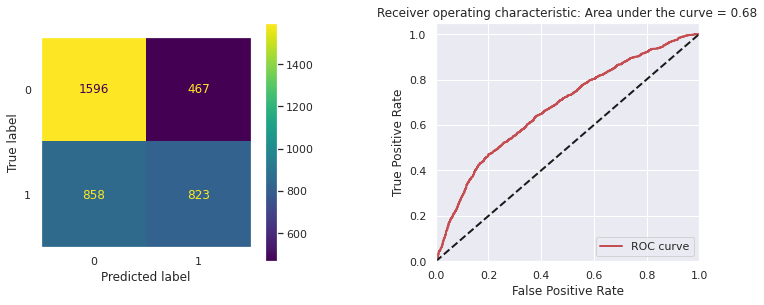

In [ ]:
evaluationDF["TestAUC"].loc["LogReg"], evaluationDF["TestLogLossCV"].loc["LogReg"], evaluationDF["ComputationTimeTestData"].loc["LogReg"] = evaluateModelOnTestData(logReg, X_test, y_test, "LogReg")

**Support Vector Machine**

Log loss of SVC model:  0.6424555512226143


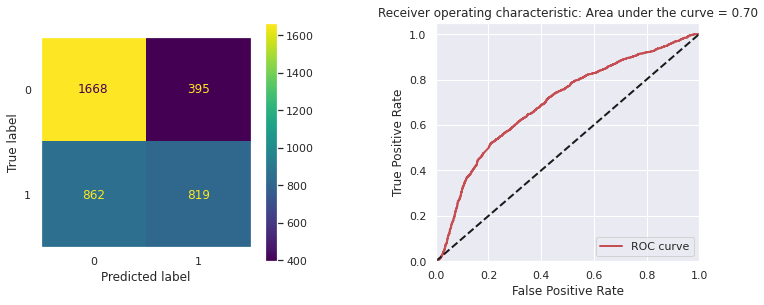

In [ ]:
evaluationDF["TestAUC"].loc["SVC"], evaluationDF["TestLogLossCV"].loc["SVC"], evaluationDF["ComputationTimeTestData"].loc["SVC"] = evaluateModelOnTestData(SVC, X_test, y_test, "SVC")

**K-Nearest-Neighbours**

Log loss of KNN model:  0.15494140180456523


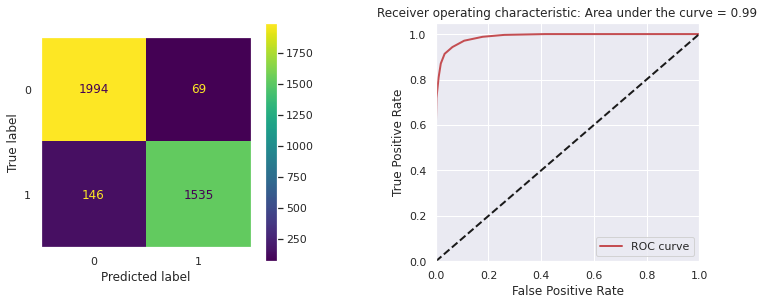

In [ ]:
evaluationDF["TestAUC"].loc["KNN"], evaluationDF["TestLogLossCV"].loc["KNN"], evaluationDF["ComputationTimeTestData"].loc["KNN"] = evaluateModelOnTestData(knn_tuned, X_test, y_test, "KNN")

**Random Forest**

Log loss of RandomForest model:  0.2680518685964371


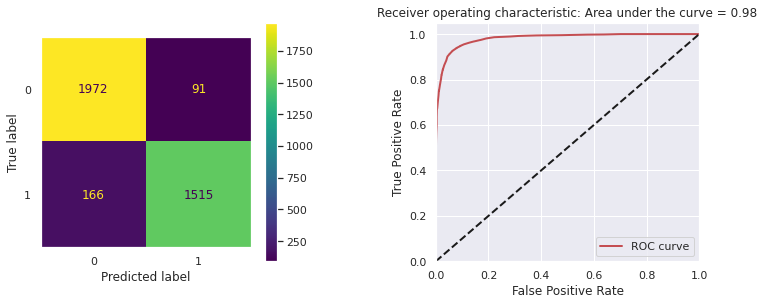

In [ ]:
evaluationDF["TestAUC"].loc["RandomForest"], evaluationDF["TestLogLossCV"].loc["RandomForest"], evaluationDF["ComputationTimeTestData"].loc["RandomForest"] = evaluateModelOnTestData(RandomForest, X_test, y_test, "RandomForest")

**Evaluation**

In [ ]:
evaluationDF.sort_values(by="TestLogLossCV", ascending=True, inplace=True)
#evaluationDF

In [ ]:
fig = go.Figure()

fig.add_trace(go.Bar(y=evaluationDF.index, x=evaluationDF["TrainingLogLossCV"], name='TrainingLogLossCV', orientation='h', marker_color='rgb(55, 83, 109)'))
fig.add_trace(go.Bar(y=evaluationDF.index, x=evaluationDF["TestLogLossCV"], name='TestLogLossCV', orientation='h', marker_color='rgb(26, 118, 255)'))
fig.add_shape(type="line", x0=BaselineLogLoss, y0=-1, x1=BaselineLogLoss, y1=evaluationDF.shape[0], line=dict(color="Red", width=2), opacity=0.5)
fig.add_trace(go.Scatter(x=[BaselineLogLoss], y=["LogReg"], text=["LogLoss Baseline"], mode="text", textfont=dict(size=12), showlegend=False))

fig.update_layout(title="LogLoss score overview", xaxis_title="LogLoss", font=dict(size=18))

fig.update_xaxes(range=[0, 0.8])

In [ ]:
fig = go.Figure()

fig.add_trace(go.Bar(x=evaluationDF.index, y=evaluationDF["TrainingAUC"], name='TrainingAUC', marker_color='rgb(55, 83, 109)'))
fig.add_trace(go.Bar(x=evaluationDF.index, y=evaluationDF["TestAUC"], name='TestAUC', marker_color='rgb(26, 118, 255)'))

fig.update_layout(title="AUC score overview", yaxis_title="AUC Score", font=dict(size=18))
fig.show()

In [ ]:
fig = go.Figure()

fig.add_trace(go.Bar(y=evaluationDF.index, x=evaluationDF["ComputationTimeTestData"], orientation='h', marker_color='rgb(55, 83, 109)', showlegend=False))
fig.update_layout(title="Time to predict x_test time overview", xaxis_title="Time to predict X_test in s", font=dict(size=18))

fig.show()

### Influence of PCA on results

I used PCA to reduce the featurespace and therefore i checked the influence of it on the *unoptimized* algorithms.
The results i gathered while keeping 8 components (96.05 % explained variance) are:

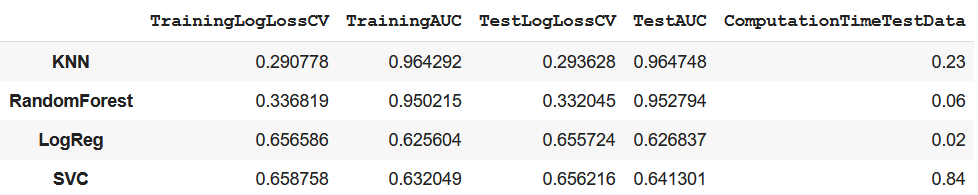
In comparism the results without a PCA:

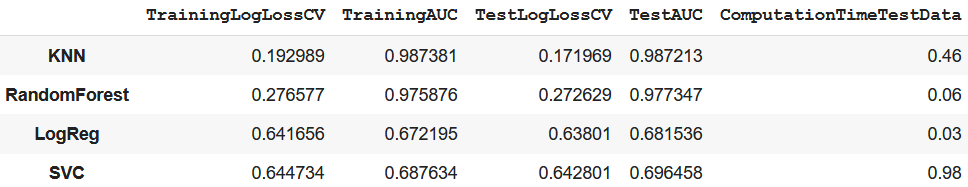
I decided not to reduce the number of features since the algorithm performs really well on the unreduced dataset in relatively short time. 

### Conclusion Phase I

After implementing the basic ML algorithms i recognized the following:


*   Implementation of basic architecture is simple, but in the beginning it is possible to get bad results. In addition to that, it depends on the underlying data wether linear approaches (LogReg, ...) are good enough or nonlinear approaches have to be used (KNN, RandomForest, ...).
*   A good way for hyperparameter optimization is using *GridSearchCV* or the *elbow plot* for KNN. 

The impact of PCA:



*   PCA is a great way to visualize the data if the input data is more than 3 dimensional. 
*   It can improve the computationtime the algorithm needs for prediction since there are less features, but the quantitative improvement depends on the individual algorithm. E.g. Good improvement in predictiontime for KNN and no improvement for RandomForest.
*   The PCA also improves the training time due to a smaller featurespace. This might be very useful for big datasets. 

Since i have a small/regular dataset in terms of machine learning i wouldn't use a PCA because there's no real need for it. Otherwise the PCA performance could be improved by tuning the hyperparameters for this case.

**Evaluation of hypothesis**

I managed to implement two classifier that perform very well in this binary classification task and therefore i already reached my initial goal with basic ML algorithms. My preference is the KNN because it has the best performance in both performance metrics. Besides that the computation time for prediction is slightly worse than RandomForestClassifiers computation time, but it is still very good.






# Testing Phase II: Model Development

I will use a sequential architecture since i want to train a basic model. Besides that, i will only use one hidden layer to start building the NN from simple to complex in *Testing Phase III* if necessary. 

Due to my binary classification task, i will use:

*  Output layer with sigmoid activation function
*  loss=BinaryCrossentropy 

In addition to that i will use the metric AUC to make the results comparable with my models from *Testing Phase I*.

## Build basic model function

In [ ]:
#simple model
def build_model(X_train, learning_rate):
  #Model initialization
  NN = models.Sequential()
  NN.add(layers.Dense(32, activation='relu', input_shape=(X_train.shape[1],)))
  NN.add(layers.Dense(1, activation='sigmoid')) #output function that predicts either a probability between 0 or 1
  opt = tf.keras.optimizers.SGD(learning_rate=learning_rate)
  NN.compile(optimizer=opt,loss='BinaryCrossentropy', metrics=['AUC'])
  return NN

## Model evaluation

Here i will define some functions to evaluate the performance of the neural network.

### Applying cross validation

In [ ]:
def buildAndEvaluateNN(X_train, y_train, num_epochs, batch_size, learning_rate=0.01, build_model_func=build_model):
  """
  build_model_func: creates basic NN by default. See section Build basic model function.
  """
  
  #Lists for storing LogLoss scores
  trainingScores = []
  cvScores = []

  #Lists for storing AUC scores
  trainingScoresAUC = []
  cvScoresAUC = []

  predictionsBasedOnKFolds = pd.DataFrame(data=[],index=y_train.index,columns=[0,1])

  #kfold.split the training data
  for train_index, cv_index in k_fold.split(np.zeros(len(X_train)),y_train.ravel()):

    #gather data of current cv fraction based in indices
    X_train_fold, X_cv_fold = X_train.iloc[train_index,:], X_train.iloc[cv_index,:]
    y_train_fold, y_cv_fold = y_train.iloc[train_index], y_train.iloc[cv_index]



    ## fit model to gathered data

    #Building the Keras model:
    model = build_model_func(X_train_fold, learning_rate)

    #Training step: Trains the model in silent mode (verbose = 0)
    model.fit(X_train_fold, y_train_fold, epochs=num_epochs, batch_size=batch_size, verbose=0)

    #Evaluating the training pperformance:
    TrainingLogLoss, TrainingAUC = model.evaluate(X_train_fold, y_train_fold, verbose=0) #BCE=BinaryCrossEntropy
    trainingScores.append(TrainingLogLoss)
    trainingScoresAUC.append(TrainingAUC)
    print('--------------------------------------------------------')
    print('Training AUC: ', TrainingAUC)

    #Evaluating the CV pperformance:
    TrainingCVLogLoss, TrainingCVAUC = model.evaluate(X_cv_fold, y_cv_fold, verbose=0)
    cvScores.append(TrainingCVLogLoss)
    cvScoresAUC.append(TrainingCVAUC)
    print('CV AUC: ', TrainingCVAUC)

  #Overall score for whole training dataset
  TrainingLogLoss_total, TrainingAUC_total = model.evaluate(X_train, y_train, verbose=0)
  print('--------------------------------------------------------')
  print('Average AUC score during CV:')
  print('Training: %5.2f' %np.mean(trainingScoresAUC))
  print('CV-Val: %5.2f' %np.mean(cvScoresAUC))
  print('--------------------------------------------------------')
  print('Average LogLoss score during CV:')
  print('Training: %5.2f' %np.mean(trainingScores))
  print('CV-Val: %5.2f' %np.mean(cvScores))
  print('--------------------------------------------------------')
  print('AUC for the entire training dataset: %5.2f' %TrainingAUC_total)
  print('LogLoss for the entire training dataset: %5.2f' %TrainingLogLoss_total)
  print('--------------------------------------------------------')

  return model, cvScores

In [ ]:
#same function as above but it stores the model history
def buildAndEvaluateNNHistory(X_train, y_train, num_epochs, batch_size, callbacks=[], learning_rate=0.01, build_model_func=build_model):
  """
  build_model_func: creates basic NN by default. See section Build basic model function.
  """
  #Lists for storing LogLoss scores
  trainingScores = []
  cvScores = []

  predictionsBasedOnKFolds = pd.DataFrame(data=[],index=y_train.index,columns=[0,1])

  #store histories for further use
  histories = []

  #kfold.split the training data
  for k, (train_index, cv_index) in enumerate(k_fold.split(np.zeros(len(X_train)),y_train.ravel())):
    print(f"{k+1}/10 fold...")
    #gather data of current cv fraction based in indices
    X_train_fold, X_cv_fold = X_train.iloc[train_index,:], X_train.iloc[cv_index,:]
    y_train_fold, y_cv_fold = y_train.iloc[train_index], y_train.iloc[cv_index]

    ## fit model to gathered data

    #Building the Keras model:
    model = build_model_func(X_train_fold, learning_rate)

    #Training step: Trains the model in silent mode (verbose = 0)
    #the scores are now stored in the history variable.
    history = model.fit(X_train_fold, y_train_fold, epochs=num_epochs, batch_size=batch_size,
                        validation_data=(X_cv_fold, y_cv_fold), verbose=0, callbacks=callbacks)

    #create history dataframe
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    histories.append(hist)

  return model, histories

In [ ]:
def train_model(X_train, y_train, num_epochs, batch_size, callbacks=[], learning_rate=0.01, build_model_func=build_model):
  """
  build_model_func: creates basic NN by default. See section Build basic model function.
  """
  
  #Building the Keras model:
  model = build_model_func(X_train, learning_rate)

  #the scores are now stored in the history variable.
  history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, verbose=1, callbacks=callbacks)

  #create history dataframe
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  return model, hist

### Average losses from histories

In [ ]:
# auxiliary function
def FindMinLength(lst):
    minList = min(lst, key = lambda i: len(i))
    minLength = len(minList)
      
    return minLength

In [ ]:
def get_averages_from_history(histories):

  maxEpochs = FindMinLength(histories)

  overall_history = pd.DataFrame(data=None, index=range(maxEpochs), columns=["avg_loss", "avg_val_loss"])

  for epoch in range(maxEpochs):
    val_loss = 0
    loss = 0
    number_of_relevant_histories = 0
    for fold_history in histories:
      if len(fold_history) > epoch:
        number_of_relevant_histories += 1
        val_loss += fold_history["val_loss"].at[epoch]
        loss += fold_history["loss"].at[epoch]
      else:
        continue

    overall_history["avg_loss"].at[epoch] = loss/number_of_relevant_histories
    overall_history["avg_val_loss"].at[epoch] = val_loss/number_of_relevant_histories

  overall_history.reset_index(drop=False, inplace=True)
  overall_history.rename(columns={"index":"epoch"}, inplace=True)

  return overall_history

In [ ]:
def get_average_loss(histories):
  avg_training_loss = 0
  avg_val_loss = 0
  for history in histories:
    avg_training_loss += history["loss"].iat[-1]
    avg_val_loss += history["val_loss"].iat[-1]

  return avg_training_loss/len(histories), avg_val_loss/len(histories)

### Learning curve functions

In [ ]:
# Defining our function to see the evolution of error: #ITS
def plot_learning_curves(histories, show_every_fold_explicit= False):
  """
  Returns either a plot with the averaged scores per epoch until the first earlyStop callback interrupts the training
  OR the learning curve of every k-th model.
  """

  if show_every_fold_explicit == False:
    #calculate average loss per epoch until the first model overfits (earliest earlystopping interrupts training)
    overall_history = get_averages_from_history(histories)

    #We will omit the first 10 points for a better visualization:
    plt.plot(overall_history['epoch'][10:], overall_history['avg_loss'][10:], "k--", linewidth=1.5, label="CV Training average")
    plt.plot(overall_history['epoch'][10:], overall_history['avg_val_loss'][10:], "b-.", linewidth=1.5, label="CV Validation average")

    plt.legend()
    plt.xlabel("Epochs"),  plt.ylabel("LogLoss")
    plt.show()
  
  else:
    #number of excluded epochs
    n_excl = 10
    fig = go.Figure()
    for k, history in enumerate(histories):
      fig.add_trace(go.Scatter(x=history['epoch'][n_excl:], y=history['loss'][n_excl:], mode='lines', name=f'{k+1}-fold CV Training loss', line=dict(color='black')))#, hoverinfo="Test"))
      fig.add_trace(go.Scatter(x=history['epoch'][n_excl:], y=history['val_loss'][n_excl:], mode='lines', name=f'{k+1}-fold CV Test loss', line=dict(color='blue')))#, hoverinfo="Test"))

    fig.update_layout(xaxis_title='Epoch', yaxis_title='LogLoss')
    
    fig.show()

  #calculate overall loss of best models
  overallTrainingLossCV, overallValLossCV = get_average_loss(histories)
  print("For comparism with other models use averaged best results of every fold:")
  print("CV Training loss: ", overallTrainingLossCV)
  print("CV Validation loss: ", overallValLossCV)

  print("Discrepancys between plot and values come from different set of best models. Example given in function.")

  #Example:
  # If the k-th model has a best fit better than the average fit at 80 epochs and no other model trains until 80 epochs the average in the plot will be based on just one loss.
  # Therefore, it isn't as robust as the printed value which is calculated based on the best loss of every of the k models.
  return

### Confusion Matrix and ROC Curve function

In [ ]:
#stackoverflow
def Find_Optimal_Cutoff(target, predicted):
    """ Find the optimal probability cutoff point for a classification model related to event rate
    Parameters
    ----------
    target : Matrix with dependent or target data, where rows are observations

    predicted : Matrix with predicted data, where rows are observations

    Returns
    -------     
    optimal cutoff threshold
        
    """
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]
    
    return list(roc_t['threshold'])[0]

In [ ]:
def evaluateNN(NN_trained, X_test, y_test, X_train, y_train, show_plots = True):

  #find optimal threshold for sigmoid constructed probability
  y_pred_train = pd.Series(NN.predict(X_train).flatten(),index=X_train.index)
  optimal_cutoff = Find_Optimal_Cutoff(y_train, y_pred_train)


  #predict X_test
  y_pred = pd.Series((NN.predict(X_test)>=optimal_cutoff).astype('int32').flatten(),index=X_test.index)

  if show_plots==True:
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))
    fig.tight_layout()
    fig.subplots_adjust(wspace=0.5)
    
    #confusion matrix
    ax1.grid(False)
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax1)

  #y_pred with probabilities to plot whole ROC curve
  y_pred = pd.Series(NN.predict(X_test).flatten(),index=X_test.index)
  #ROC
  preds = pd.concat([y_test, y_pred], axis=1)
  preds.columns = ['trueLabel','prediction']

  fpr, tpr, thresholds = roc_curve(preds['trueLabel'],preds['prediction'])
  areaUnderROC = auc(fpr, tpr)
  if show_plots==True:
    plt.axes(ax2) #change active axes
    plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: Area under the curve = {0:0.2f}'.format(areaUnderROC))
    plt.legend(loc="lower right")
    plt.show()

  return 

## Basic neural network

In [ ]:
NN = build_model(X_train, learning_rate=0.01)
NN.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 32)                480       
                                                                 
 dense_11 (Dense)            (None, 1)                 33        
                                                                 
Total params: 513
Trainable params: 513
Non-trainable params: 0
_________________________________________________________________




```
#Model training

#Hyperparameters
num_epochs = 50
batch_size = 10

NN, NN_history = buildAndEvaluateNNHistory(X_train, y_train, num_epochs, batch_size)

plot_learning_curves(NN_history)
```



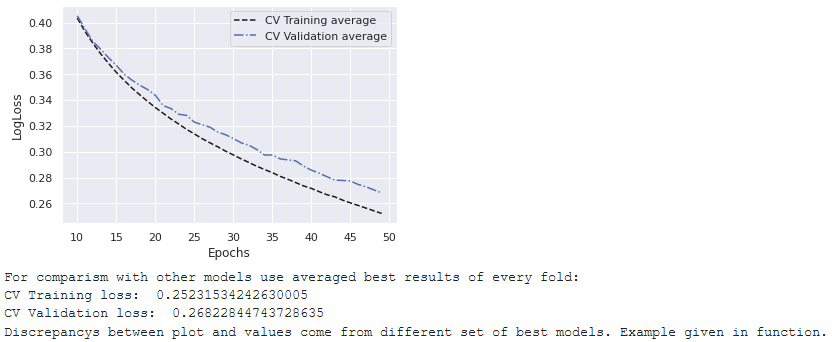

### Prediction performance

Check the NN prediction performance before fine tuning the model. The threshold when a prediction of the NN is classified as 0 or 1 is optimized to get the maximum AUC in the training data. See Model Evaluation for function.

```
evaluateNN(NN, X_test, y_test, X_train, y_train)
```

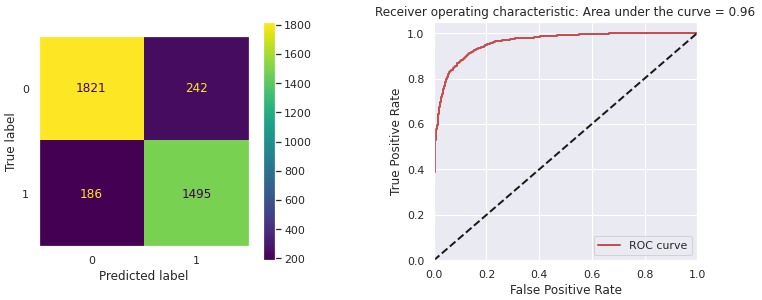


### Conclusion Phase II

The neural network perform really good with just 1 hidden layer. Furthermore, i have to increase the epochs since the learning curve tells us, that the LogLoss is still decreasing and therefore the maximum performance of this architecture isn't reached yet.

# Testing Phase III: Model Regularization and Hyperparameter optimization

## Epochs

As the following learning curve describes the Validation score doesn't improve anymore much after ~260 epochs.

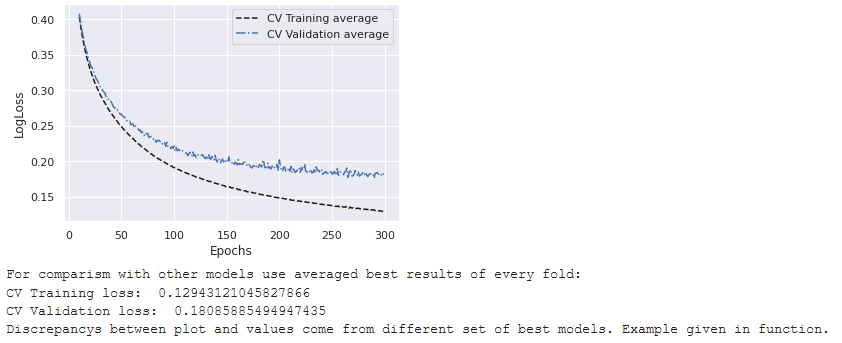


```
#Model training

#Hyperparameters
num_epochs = 300
batch_size = 10

#Build models and evaluate performance
NN, NN_history = buildAndEvaluateNNHistory(X_train, y_train, num_epochs, batch_size)

plot_learning_curves(NN_history)
```

The following evaluation returned
```
evaluateNN(NN, X_test, y_test, X_train, y_train)
```


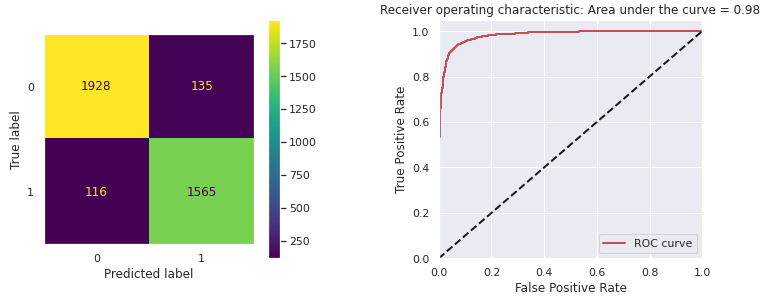

The NN training is *very* slow. It took colab ~1h to train the NN with the given hyperparameters. I will try to improve this by implementing a dynamical learning rate and early stopping for faster results.

### Callbacks

As shown in the section above the scores where still improving (decreasing slowly) after 300 epochs. In order to train the given architecture to its full potential i will introduce some callbacks to stop training when the score decreases and get the best model with the given architecture. I will implement the following callbacks:

*  EarlyStopping: Interrupting the training process if no improvements occur.
*  DynamicalLr: I will start with a larger learning rate to reach better areas faster. After that the callback will reduce the LR incrementally.


In [ ]:
# patience = Number of tolerated epochs without improvement before interrupting training
# restore_best_weights=True to use the best NN found
earlyStopping = keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)

# reduce learning rate on plateau by factor after waiting x number without val_loss improvement
reduceLr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=3, min_lr=0.001)


```
# Hyperparameters
num_epochs = 1000
batch_size = 10

# Build models and evaluate performance
NN, NN_history = buildAndEvaluateNNHistory(X_train, y_train, num_epochs, batch_size, callbacks=[earlyStopping, reduceLr], learning_rate=0.05)

plot_learning_curves(NN_history)
```


After implementing the callbacks to reduce training time i increased the epoch number to 1000 and received this learning curve:

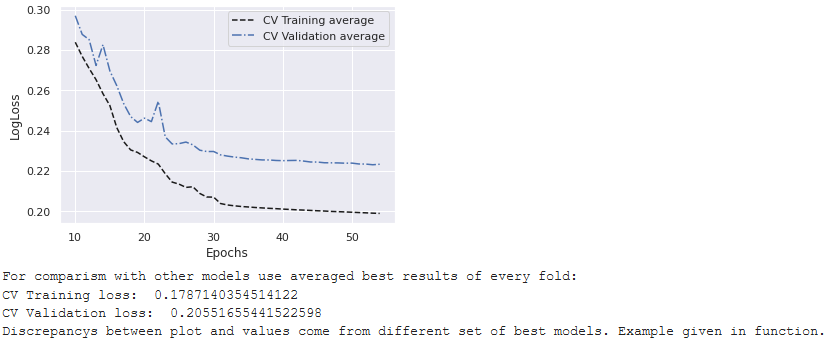

My early stop kicked in and stopped the training after ~55 epochs. The rough start is caused by a larger learning rate of 0.05 (prior used: 0.01). The learning curve tells us that the model is still underfitted, but my early stopping interrupted the training. Hence, i can't just increase the epochs for a better result. So i will add more hidden layers.

## More hidden layers

According to the lecture it's better to use a larger model than a highly specialized simple one.

### Large neural network

In [ ]:
def build_large_model(X_train, learning_rate):
  #Model initialization
  NN = models.Sequential()
  NN.add(layers.Dense(32, activation='relu', input_shape=(X_train.shape[1],)))
  NN.add(layers.Dense(32, activation='relu'))
  NN.add(layers.Dense(32, activation='relu'))
  NN.add(layers.Dense(1, activation='sigmoid')) #output function that predicts either a probability between 0 or 1
  opt = tf.keras.optimizers.SGD(learning_rate=learning_rate)
  NN.compile(optimizer=opt,loss='BinaryCrossentropy', metrics=['AUC'])
  return NN

By using a more hidden layers i received a even better score after much less training time. After just ~130 epochs my early stopping kicked in (24min training time).



```
# Hyperparameters
num_epochs = 300
batch_size = 10

# Build models and evaluate performance
NN, NN_history = buildAndEvaluateNNHistory(X_train, y_train, num_epochs, batch_size, callbacks=[earlyStopping, reduceLr], learning_rate=0.05, model_type="large")

plot_learning_curves(NN_history)
```

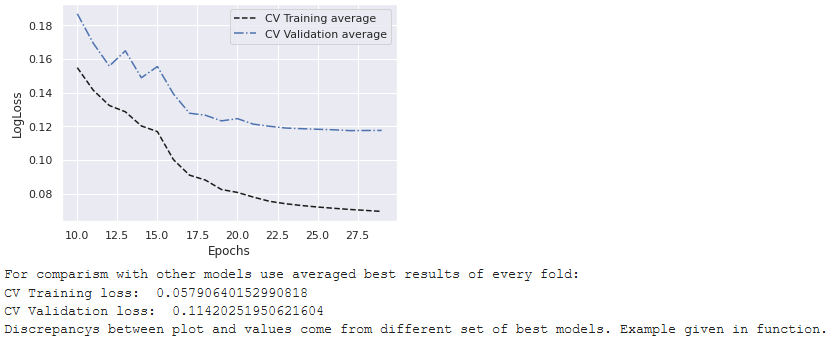


The evaluation of this net is tested via

```
evaluateNN(NN, X_test, y_test, X_train, y_train)
```

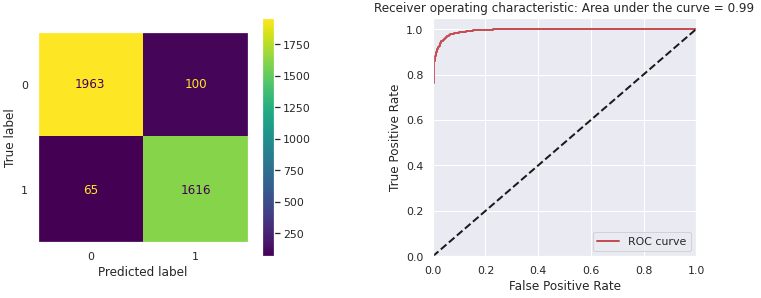

### Extra large neural network

In [ ]:
def build_extra_large_model(X_train, learning_rate):
  #Model initialization
  NN = models.Sequential()
  NN.add(layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
  NN.add(layers.Dense(64, activation='relu'))
  NN.add(layers.Dense(64, activation='relu'))
  NN.add(layers.Dense(1, activation='sigmoid')) #output function that predicts either a probability between 0 or 1
  opt = tf.keras.optimizers.SGD(learning_rate=learning_rate)
  NN.compile(optimizer=opt,loss='BinaryCrossentropy', metrics=['AUC'])
  return NN

I increased the number of hidden layers and the number of neurons per layer to get an extra large neural network.

```
# Hyperparameters
num_epochs = 300
batch_size = 10

# Build models and evaluate performance
NN, all_histories = buildAndEvaluateNNHistory(X_train, y_train, num_epochs, batch_size, callbacks=[modelCheckpoint, earlyStopping, reduceLr], learning_rate=0.05, build_model_func=build_extra_large_model)

plot_learning_curves(all_histories)
```

It yields:

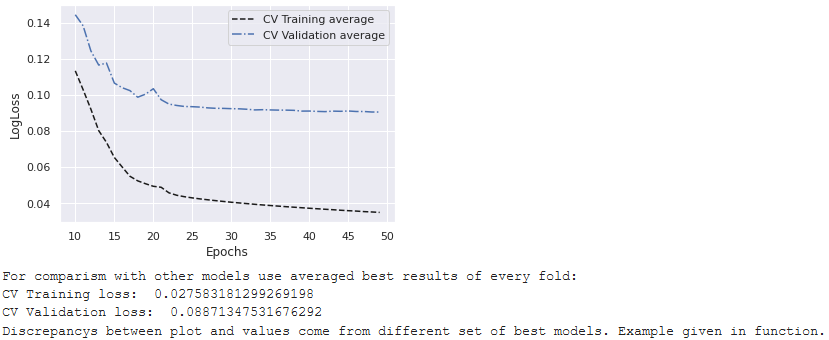

```
evaluateNN(NN, X_test, y_test, X_train, y_train)
```

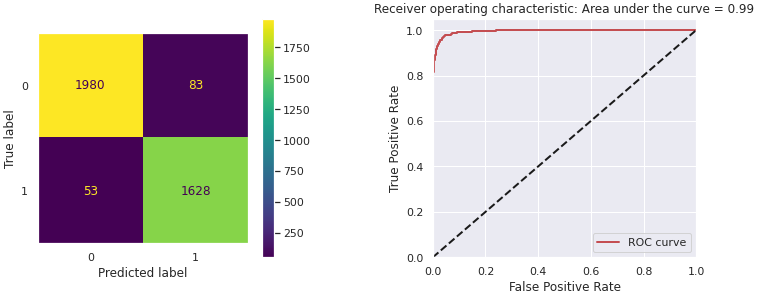


## Regularization

### Overfitting neural network

To see how an overfitting neural network would look like i'll create a huge one that will hopefully overfit.

In [ ]:
def build_XXL_model(X_train, learning_rate):
  #Model initialization
  NN = models.Sequential()
  NN.add(layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
  NN.add(layers.Dense(256, activation='relu'))
  NN.add(layers.Dense(256, activation='relu'))
  NN.add(layers.Dense(256, activation='relu'))
  NN.add(layers.Dense(256, activation='relu'))
  NN.add(layers.Dense(1, activation='sigmoid')) #output function that predicts either a probability between 0 or 1
  opt = tf.keras.optimizers.SGD(learning_rate=learning_rate)
  NN.compile(optimizer=opt,loss='BinaryCrossentropy', metrics=['AUC'])
  return NN

To get an overfitting network i need to adapt the earlyStopping. It has to monitor the training loss instead of the validationloss.

In [ ]:
# reduce learning rate on plateau by factor after waiting x number without val_loss improvement
# i will monitor thr training loss, since it should converge in a later epoch than the test loss. Therefore it is useful for generating an overfitted NN.
reduceLrLoss = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.01, patience=3, min_lr=0.01)

I created an overfitted NN to get an insight on how good a Validation score of a fairly complex model would look like for a general orientation. Since i assume that the training data is similar to the test data a good validation score would lead to a good test score and therefore to a good overall performance.


```
# Hyperparameters
num_epochs = 300
batch_size = 10

# Build models and evaluate performance
NN, all_histories = buildAndEvaluateNNHistory(X_train, y_train, num_epochs, batch_size, callbacks=[reduceLrLoss],
                                           learning_rate=0.05, build_model_func=build_XXL_model)

plot_learning_curves(all_histories)
```

Which has the following learning curve:

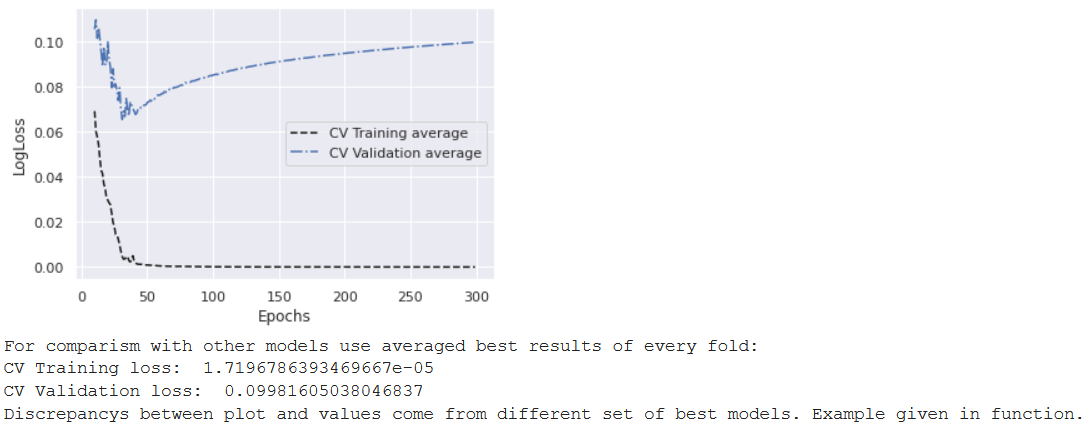

Now i abandoned my strategy to increase the models complexity to find the best model. I will now try to start with the overfitting architecture and try to get control over it to receive the best model possible that isn't overfitting.

### Getting control over the overfitted NN (1/3)

*Base model*

In this section i will use the callbacks earlyStopping and reducedLR based on the val_loss to get control over the overfitted NN.


```
# Hyperparameters
num_epochs = 300
batch_size = 10

# Build models and evaluate performance
NN, all_histories = buildAndEvaluateNNHistory(X_train, y_train, num_epochs, batch_size, callbacks=[reduceLr, earlyStopping],
                                           learning_rate=0.05, build_model_func=build_XXL_model)

plot_learning_curves(all_histories)                                           
```

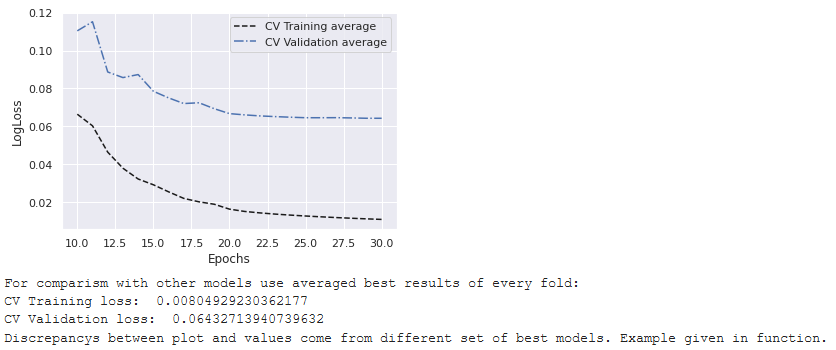

The model has the best performance at epoch 30. In epoch 31 the first model (of the trained k-models) doesn't improve it's loss anymore and plateaus. Therefore, i will train a model with this hyperparameter. I can't just simply use the last trained model since it was only trained on 9/10 of the training data. A model trained on the whole training dataset might perform better.

*Tuned model*



```
#Use optimal number of epochs
num_epochs = 30

NN = train_model(X_train, y_train, num_epochs, batch_size, callbacks=[reduceLr],
                                           learning_rate=0.05, build_model_func=build_XXL_model)


#evaluate performance on test dataset                                          
evaluateNN(NN, X_test, y_test, X_train, y_train)
```

Its performance on the testdata (**unseen**) is almost perfect!

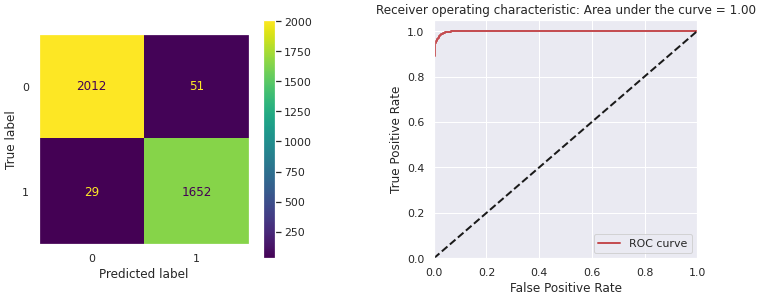





### Getting control over the overfitted NN (2/3)

In this section i will try to get control over the overfitted NN by using weight regularization. Weight regularization punishes the network if it creates large weights. This is useful because large weights can lead to unstable behaviour during the learning process [[1]]. Large weights magnify minor input changes to large output changes. A behaviour that is unwanted because we want a robust NN. We can encourage the NN to stick to smaller weights by adding a term that contains a regularization parameter and the weights to the loss term that the network tries to optimize.

[1]: https://machinelearningmastery.com/weight-regularization-to-reduce-overfitting-of-deep-learning-models/

*Base model*



```
# Hyperparameters
num_epochs = 150
batch_size = 10

for c in [0.1, 0.01, 0.001]:
  def build_XXL_model_weight_regularized(X_train, learning_rate):
    #Model initialization
    NN = models.Sequential()
    NN.add(layers.Dense(256,  kernel_regularizer=regularizers.l2(c), activation='relu', input_shape=(X_train.shape[1],)))
    NN.add(layers.Dense(256,  kernel_regularizer=regularizers.l2(c), activation='relu'))
    NN.add(layers.Dense(256,  kernel_regularizer=regularizers.l2(c), activation='relu'))
    NN.add(layers.Dense(256,  kernel_regularizer=regularizers.l2(c), activation='relu'))
    NN.add(layers.Dense(256,  kernel_regularizer=regularizers.l2(c), activation='relu'))
    NN.add(layers.Dense(1, activation='sigmoid')) #output function that predicts either a probability between 0 or 1
    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    NN.compile(optimizer=opt,loss='BinaryCrossentropy', metrics=['AUC'])
    return NN

  # Build models and evaluate performance
  NN, all_histories = buildAndEvaluateNNHistory(X_train, y_train, num_epochs, batch_size, callbacks=[reduceLrLoss],
                                            learning_rate=0.05, build_model_func=build_XXL_model_weight_regularized)
  
  #store histories as csv
  all_histories[0].to_csv(f"/content/gdrive/My Drive/histories_{c}_weight_regularization")


all_histories_weight_regularized = {}
# load stored histories and create dictionary
for c in [0.1, 0.01, 0.001]:
  all_histories_weight_regularized[c] = pd.read_csv(f"/content/gdrive/My Drive/histories_{c}_weight_regularization").drop(columns=["Unnamed: 0"], axis=1)


# plot learning curves
for key in list(all_histories_weight_regularized.keys()):
  print(f"Chosen weight regularization: {key}.")
  plot_learning_curves([all_histories_weight_regularized[key]])
  print()
```


It returns:

[regularization coeff: 0.1]

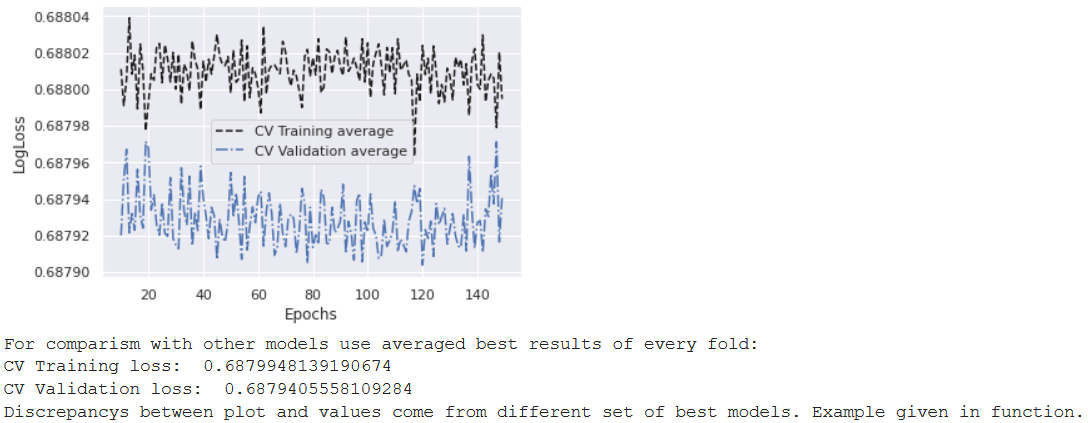


[regularization coeff: 0.01]
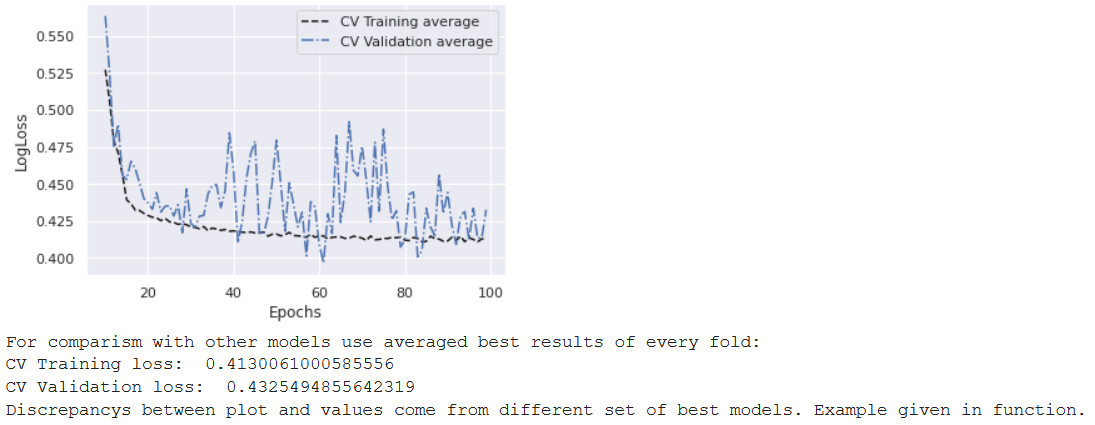

[regularization coeff: 0.001]
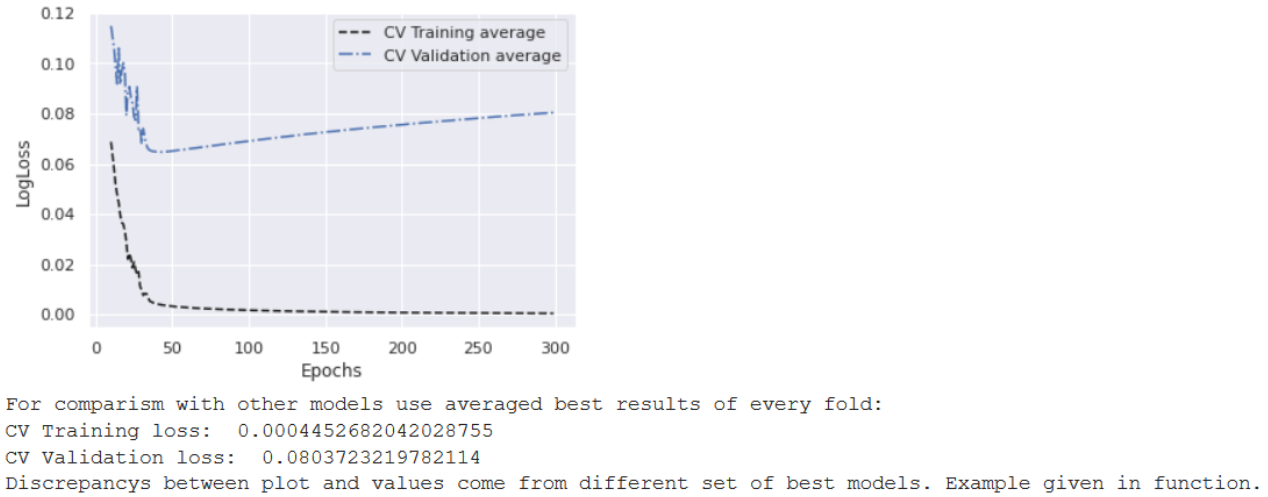

The learning curves tell us, that the models with the regularization coefficient of 0.1 and 0.01 underfit because the model punishes large weights too strong and therefore it doesn't learn. On the other hand the model with the regularization coefficient of 0.001 overfits. Therefore, the optimal choice is in between 0.001 and 0.01.

*Tuned model*

I will not finetune the model since i have other approaches that propose good results.

### Getting control over the overfitted NN (3/3)

In this section i want to try the regularization method dropout to get control over my overfitted NN. I will use half the number of epochs from the overfitting model since it should be enough to show the overfitting characteristic while training faster.

*Base model*



```
# Hyperparameters
num_epochs = 300
batch_size = 10

for dropoutrate in [0.15, 0.2, 0.3, 0.4]:
  #define NN with custom dropout rate
  def build_XXL_model_dropout(X_train, learning_rate):
    #Model initialization
    NN = models.Sequential()
    NN.add(layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
    NN.add(layers.Dropout(dropoutrate))
    NN.add(layers.Dense(256, activation='relu'))
    NN.add(layers.Dropout(dropoutrate))
    NN.add(layers.Dense(256, activation='relu'))
    NN.add(layers.Dropout(dropoutrate))
    NN.add(layers.Dense(256, activation='relu'))
    NN.add(layers.Dropout(dropoutrate))
    NN.add(layers.Dense(256, activation='relu'))
    NN.add(layers.Dropout(dropoutrate))
    NN.add(layers.Dense(1, activation='sigmoid')) #output function that predicts either a probability between 0 or 1
    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    NN.compile(optimizer=opt,loss='BinaryCrossentropy', metrics=['AUC'])
    return NN

  # Build models and evaluate performance
  NN, all_histories = buildAndEvaluateNNHistory(X_train, y_train, num_epochs, batch_size, callbacks=[reduceLrLoss],
                                            learning_rate=0.05, build_model_func=build_XXL_model_dropout)

  #store histories as csv
  all_histories[0].to_csv(f"/content/gdrive/My Drive/histories_{dropoutrate}dropoutrate")


all_histories_dropout = {}
# load stored histories and create dictionary
for dropoutrate in np.linspace(0.2, 0.4, 3):
  all_histories_dropout[np.round(dropoutrate,2)] = pd.read_csv(f"/content/gdrive/My Drive/histories_{np.round(dropoutrate,2)}dropoutrate").drop(columns=["Unnamed: 0"], axis=1)


#plot learning curves
for key in list(all_histories_dropout.keys()):
  print(f"Chosen dropoutrate: {key}.")
  plot_learning_curves([all_histories_dropout[key]])
  print()

```
Which returns:

[Chosen dropoutrate: 0.15]
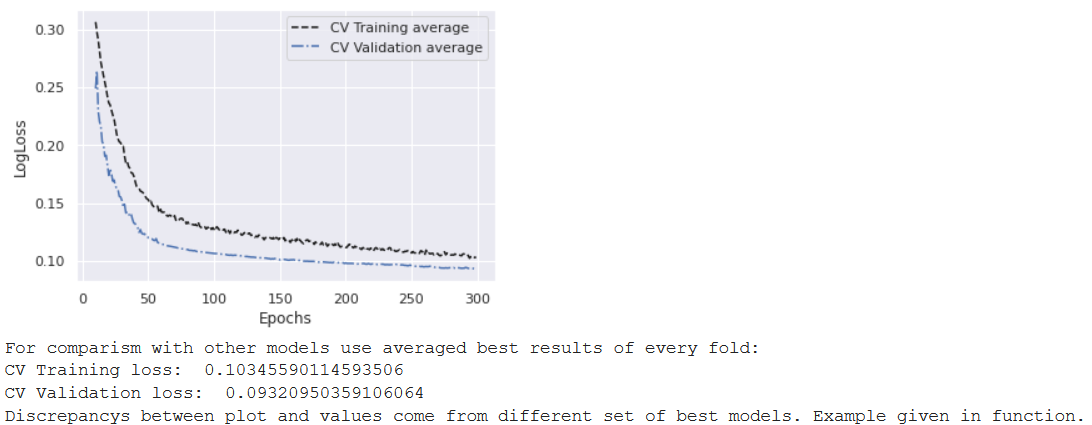

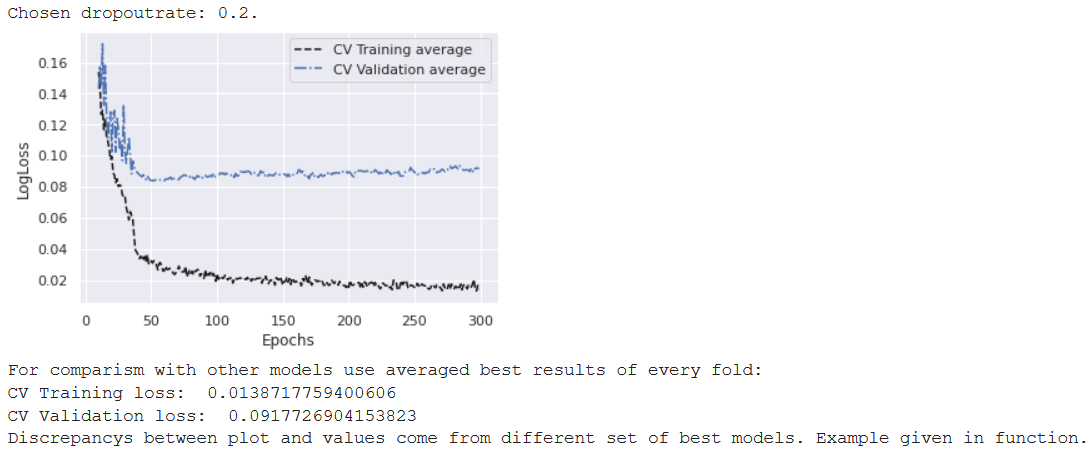

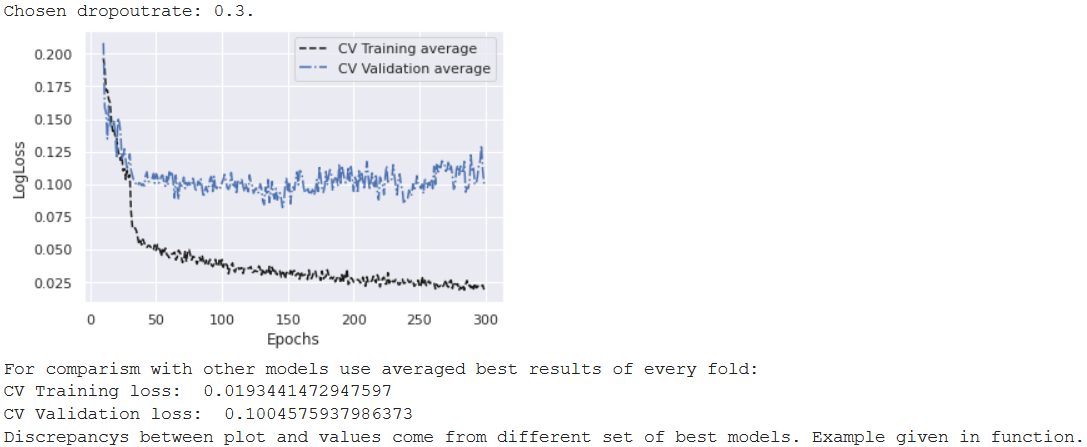

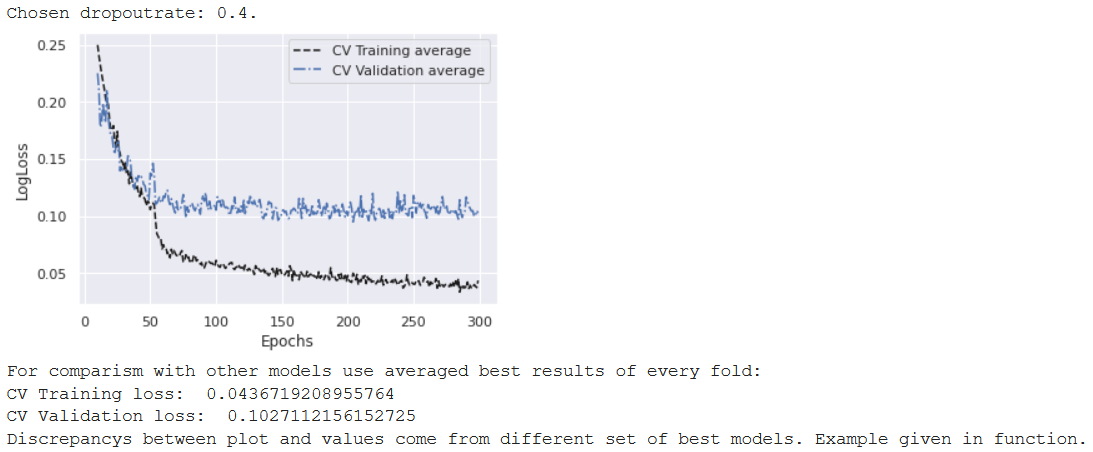

As the learning curves imply the model with a dropoutrate of 0.15 underfits while the models with dropoutrates of 0.3 and 0.4 overfit. The model with dropoutrate 0.2 plateaus with a very slight overfit and therefore is closer to the optimal architecture than the others. Hence i will choose 0.19 dropoutrate for further training.

*Tuned model*

In [ ]:
def build_XXL_model_dropout(X_train, learning_rate):
  #Model initialization
  NN = models.Sequential()
  NN.add(layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
  NN.add(layers.Dropout(0.19))
  NN.add(layers.Dense(256, activation='relu'))
  NN.add(layers.Dropout(0.19))
  NN.add(layers.Dense(256, activation='relu'))
  NN.add(layers.Dropout(0.19))
  NN.add(layers.Dense(256, activation='relu'))
  NN.add(layers.Dropout(0.19))
  NN.add(layers.Dense(256, activation='relu'))
  NN.add(layers.Dropout(0.19))
  NN.add(layers.Dense(1, activation='sigmoid')) #output function that predicts either a probability between 0 or 1
  opt = tf.keras.optimizers.SGD(learning_rate=learning_rate)
  NN.compile(optimizer=opt,loss='BinaryCrossentropy', metrics=['AUC'])
  return NN



```
# Hyperparameters
num_epochs = 300
batch_size = 10

# Build models and evaluate performance
NN, all_histories = buildAndEvaluateNNHistory(X_train, y_train, num_epochs, batch_size, callbacks=[reduceLrLoss],
                                            learning_rate=0.05, build_model_func=build_XXL_model_dropout)

#plot learning curves
plot_learning_curves(all_histories)                                           
```



It returns

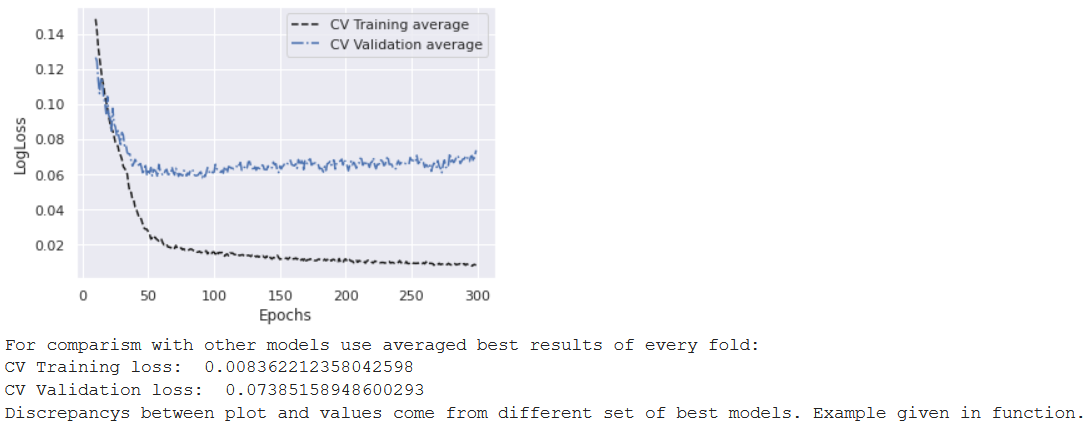

The Learning curve shows that the NN ist still slightly overfitting. Nethertheless it still performs good. A good idea might be to use add the callback modelcheckpoint to store the model that was trained at epoch ~80.

## Overall best model

In [ ]:
filepath="/content/gdrive/My Drive/epochs:{epoch:03d}-val_loss:{val_loss:.3f}.hdf5"

modelCheckpoint = keras.callbacks.ModelCheckpoint(filepath=filepath,
                                                  save_weights_only=True,
                                                  monitor='val_loss',
                                                  mode='min',
                                                  save_best_only=True)

I received my best performing model by using a dropoutrate of 0.19 in combination with modelcheckpoint to store the best performing model found during the training.

```
# Hyperparameters
num_epochs = 100
batch_size = 10

# Build models and evaluate performance
NN, all_histories = buildAndEvaluateNNHistory(X_train, y_train, num_epochs, batch_size, callbacks=[reduceLrLoss, modelCheckpoint],
                                            learning_rate=0.05, build_model_func=build_XXL_model_dropout)

# plot learning curves
plot_learning_curves(all_histories)      
```

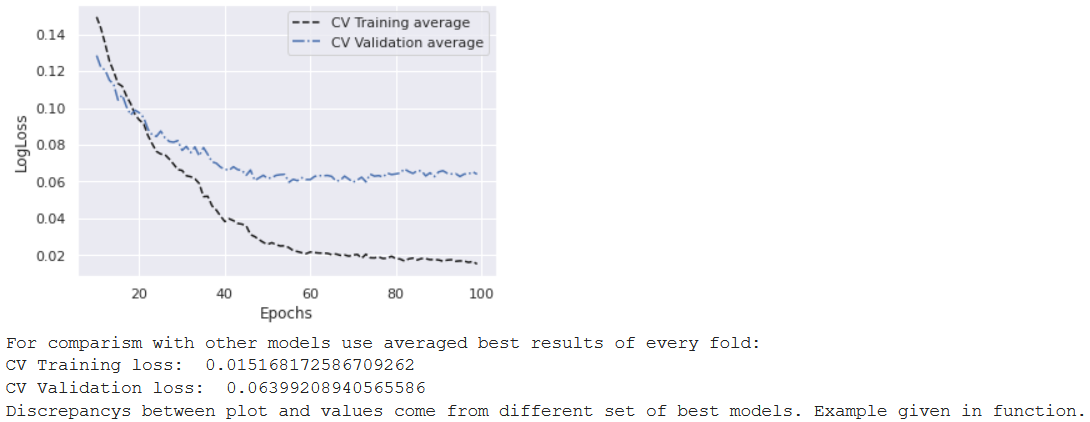

Loading the optimal NN from epoch 58 (weights were stored by modelCheckpoint) and testing it on the test data returned:
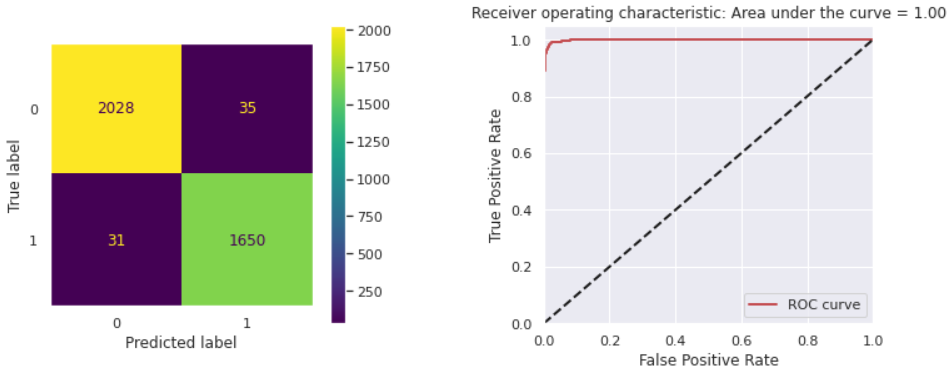

This is the best score i received during the whole project. This model correctly classifies ~98,24% of the testdata.


## Conclusion Phase III

**Further ideas for NN:**

Further approaches to develop classification algorithms for this problem could be to use an ensemble of multiple NN in combination with simpler algorithms from phase I. Such ensemble models are exhaustive to tune due to the amount of hyperparameters. Another idea would be to combine multiple regularization methods for NN.




**Further questions:**

KNN and decision trees are NOT based on the quantity of the data, but their results are based on the distribution of data [[1]]. Due to my very good results in KNN and RFC it seems that the two classes can be separated quite good from each other. This also explains the outstanding performance of my NN. Besides that the classes might not be separatable by linear or kernel based approaches due to clusters that can not be separated by these methods.

[1]: https://towardsdatascience.com/breaking-the-curse-of-small-datasets-in-machine-learning-part-1-36f28b0c044d


# Testing Hypothesis

In this last section of my project i will try to find out wether my hypothesis *KNN and RFC work so well on this data because the data are pretty well clustered.* is true.

## Prepare environment

In [ ]:
# ML Algorithms to be used
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import fcluster, linkage
from scipy.cluster.hierarchy import dendrogram, cophenet
from scipy.spatial.distance import pdist
from sklearn.cluster import DBSCAN
from sklearn.mixture import BayesianGaussianMixture

Use the standardized data from previous task.

In [ ]:
dataX.describe()

,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4
count,1.497600e+04,1.497600e+04,1.497600e+04,1.497600e+04,1.497600e+04,1.497600e+04,1.497600e+04,1.497600e+04,1.497600e+04,1.497600e+04,1.497600e+04,1.497600e+04,1.497600e+04,1.497600e+04
mean,4.627857e-15,-1.019461e-15,-3.082155e-16,-2.966698e-15,-1.709204e-14,1.260361e-14,3.075731e-15,1.964635e-14,3.136403e-14,-1.359408e-14,1.087056e-14,-1.809685e-14,1.171336e-14,-1.930918e-15
std,1.000033e+00,1.000033e+00,1.000033e+00,1.000033e+00,1.000033e+00,1.000033e+00,1.000033e+00,1.000033e+00,1.000033e+00,1.000033e+00,1.000033e+00,1.000033e+00,1.000033e+00,1.000033e+00
min,-2.738452e+00,-3.452317e+00,-3.123724e+00,-3.054058e+00,-2.172151e+00,-2.911473e+00,-2.232146e+00,-2.650306e+00,-3.007308e+00,-3.965700e+00,-4.173742e+00,-3.884876e+00,-4.877541e+00,-4.046208e+00
25%,-5.525325e-01,-6.227949e-01,-6.479397e-01,-6.769481e-01,-5.745526e-01,-4.466619e-01,-7.113049e-01,-6.089465e-01,-5.925714e-01,-5.409989e-01,-4.858150e-01,-5.673494e-01,-4.562219e-01,-5.004861e-01
50%,-1.858298e-01,-1.285508e-01,-7.141288e-02,-8.924058e-02,-1.523679e-01,-1.139881e-01,-1.225766e-01,-1.340469e-01,-1.037946e-01,-9.982015e-02,-6.701091e-02,-1.079920e-01,-8.770387e-02,-1.672543e-01
75%,2.756597e-01,4.511140e-01,3.134071e-01,4.745764e-01,3.303809e-01,3.569399e-01,5.149334e-01,4.531710e-01,4.421557e-01,4.192733e-01,3.730398e-01,4.026263e-01,3.421840e-01,2.993223e-01
max,5.367400e+00,4.899643e+00,5.721510e+00,6.110357e+00,7.175300e+00,7.391156e+00,5.052111e+00,6.324805e+00,6.651079e+00,6.645864e+00,5.318196e+00,5.915413e+00,6.820738e+00,5.511204e+00


In [ ]:
dataY.describe()

count    14976.000000
mean         0.448851
std          0.497394
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: eyeState, dtype: float64

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(dataX,
                                                    dataY, test_size=0.25,
                                                    random_state=2020, stratify=dataY)

## Clustering 

### DBScan


In [ ]:
def cluster_homogenity(df):
  #calculate cluster homogenity

  homogenity_open = []
  for clusterID in list(DBSCANDF["cluster"].unique()):
    tmp = DBSCANDF[DBSCANDF["cluster"] == clusterID].copy()
    n_open = tmp[tmp["eyeState"] == 0].copy()

    curr_homogenity_open = n_open.shape[0]/tmp.shape[0]
    #print(f"Homogenity of open eye state in cluster {clusterID} (with #instances: {tmp.shape[0]}) is: {curr_homogenity_open}.")
    homogenity_open.append(curr_homogenity_open)

  homogenities_good = [i for i in homogenity_open if (i == 1.0 or i == 0.0)]
  clustering_performance = np.round(len(homogenities_good)/len(homogenity_open)*100,2)
  number_of_clusters = len(homogenity_open)
  print(f"There are {number_of_clusters} clusters.")
  print(f"{clustering_performance}% of points correctly clustered.")

  return number_of_clusters, clustering_performance

In [ ]:
performancesDF = pd.DataFrame(data=None, columns=["Distance", "Number of clusters", "percent correctly clustered"])
for distance in np.arange(0.5, 1.5, 0.01):
  distance = np.round(distance, 2) 
  eps=distance         # The maximum distance between two samples for one to be considered as in the neighborhood of the other. 
  min_samples=5        # The number of samples (or total weight) in a neighborhood for a point to be considered as a core point.
                       # This includes the point itself.
  metric='euclidean'   # metric to use when calculating distance between instances in a feature array. 
  algorithm='auto'     # The algorithm to be used by the NearestNeighbors module to compute pointwise distances and find nearest neighbors. 
                       # {‘auto’, ‘ball_tree’, ‘kd_tree’, ‘brute’}
  #leaf_size=30         # Leaf size passed to BallTree or cKDTree.  The optimal value depends on the nature of the problem.

  dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric=metric, algorithm=algorithm)

  #predict clusters
  X_train_DBSCAN = dbscan.fit_predict(X_train)

  #merge predicted clusters df with index of X_train
  X_train_DBSSCANDF = pd.DataFrame(data= X_train_DBSCAN, index=X_train.index, columns=['cluster'])

  #add true labels to df
  DBSCANDF = X_train_DBSSCANDF.merge(y_train.to_frame(), left_index=True, right_index=True)

  #determine performance
  print(f"Distance: {distance}.")
  number_of_clusters, clustering_performance = cluster_homogenity(DBSCANDF)
  print()

  performancesDF.loc[len(performancesDF.index)] = [distance, number_of_clusters, clustering_performance]

Distance: 0.5.
There are 6 clusters.
83.33% of points correctly clustered.

Distance: 0.51.
There are 7 clusters.
85.71% of points correctly clustered.

Distance: 0.52.
There are 8 clusters.
87.5% of points correctly clustered.

Distance: 0.53.
There are 8 clusters.
87.5% of points correctly clustered.

Distance: 0.54.
There are 11 clusters.
90.91% of points correctly clustered.

Distance: 0.55.
There are 20 clusters.
95.0% of points correctly clustered.

Distance: 0.56.
There are 26 clusters.
96.15% of points correctly clustered.

Distance: 0.57.
There are 33 clusters.
96.97% of points correctly clustered.

Distance: 0.58.
There are 44 clusters.
97.73% of points correctly clustered.

Distance: 0.59.
There are 60 clusters.
91.67% of points correctly clustered.

Distance: 0.6.
There are 73 clusters.
93.15% of points correctly clustered.

Distance: 0.61.
There are 84 clusters.
92.86% of points correctly clustered.

Distance: 0.62.
There are 100 clusters.
90.0% of points correctly cluster

In [ ]:
fig = px.scatter(performancesDF, x="Number of clusters", y="percent correctly clustered",
                 hover_data=['Distance'])
fig.show()

As shown in the plot above the distance that returns the best clustering performance is 0.58. With this distance the DBScan algorithm identifies 44 clusters in the training dataset. This setup classifies 97.73% of the data correctly.

Based on the assumption that these clusters contain some clusters that contain each other (e.g. two concentric circles where the inner circle represents instances of class A and the outer circles represent instances of class B) this could be a possible explaination why linear approaches like SVM and Logistic Regression failed while non linear approaches performed pretty well.

# Project Summary

## Evaluation

My initial goal was to create a classifier that determines the eye state based on the given electrode measurements. During my project i tried to meet this goal as good as possible by using algorithms of different complexity levels. In training phase I i tested the simpler algorithms and managed to get a really well performing KNN algorithm. It correctly classified ~94,3% of the test data. After analyzing the impact of the PCA on my results and computing performances i created multiple NN. After tuning the hyperparameters and using regularization methods i received a NN that correctly classifies ~98,23% of the test data. In my opinion this is an outstanding performance and therefore i completely met my goal to classify the eyestate based on the given EEG data. These performances might increase even further with more data.

## Lessons learnt
- interesting field and useful to gain insights even if it seems impossible to extract knowledge from a huge amount of data
- machine learning is neverending cycle of gaining insights, asking questions to the data and answering these questions
- some simple models might perform really well while others perform just slightly better than random guessing based on the class probability
- Even if the simple models perform very well, NN will outperform them if they are tuned properly
- tuning NN properly is very time consuming
- cross validation is always helpful to get an insight on how good the model will perform on the test data